In [1]:
#default_exp verbatims/sentiment

In [2]:
#all_slow

In [3]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Verbatims - Sentiment

> This module defines the training configuration object, data preparation, training, optimization, and inference code for our multilabel classification task that attempts to predict 8 labels for each document (is very positive, is positive, is very negative, is negative, is suggestion, feels threatened, has profanity, and is nonsense).

In [4]:
#export
import os, datetime, gc
import sklearn.metrics as skm
from fastai.text.all import *
from transformers import *

import optuna

from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.core import *

from tritonlytics_ai.utils import *

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

In [5]:
#hide
import pdb

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [6]:
#hide
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.7.1+cu110
Using fastai 2.2.7
Using transformers 4.3.3


In [7]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Training configuration

In [8]:
#export
train_config = {
    'm_pre': '',
    'm_suf': '_multilabel_hf',
    'base_model_name': 'verbatim_sent',
    
    'orig_txt_col': 'answer_text',
    'txt_col': '_text_',
    'max_seq_length': 256,
    'batch_size': 8,
    'corpus_suf': '_ans',
    'train_data': SENTIMENT_CLS_PATH/'train.csv',
    'valid_data': SENTIMENT_CLS_PATH/'test.csv',
    
    'opt_beta': 1, 
    'opt_beta_average': 'weighted',
    'opt_beta_sample_weight': None,
    'opt_start': 0.08, 
    'opt_end': 0.7,
    
    'save_model_monitor': 'fbeta_score', 
    'save_model_comp': np.greater,
    'learner_path': SENTIMENT_CLS_PATH
}

train_config.update({
    'cache_data_path': SENTIMENT_CLS_PATH/f"data_{train_config['base_model_name']}.pkl",
    'save_model_filename': f"{train_config['m_pre']}{train_config['base_model_name']}{train_config['m_suf']}_bestmodel",
    'export_filename': f"{train_config['m_pre']}{train_config['base_model_name']}{train_config['m_suf']}_export.pkl",
})

In [9]:
train_config

{'m_pre': '',
 'm_suf': '_multilabel_hf',
 'base_model_name': 'verbatim_sent',
 'orig_txt_col': 'answer_text',
 'txt_col': '_text_',
 'max_seq_length': 256,
 'batch_size': 8,
 'corpus_suf': '_ans',
 'train_data': Path('data/classification/sentiment/train.csv'),
 'valid_data': Path('data/classification/sentiment/test.csv'),
 'opt_beta': 1,
 'opt_beta_average': 'weighted',
 'opt_beta_sample_weight': None,
 'opt_start': 0.08,
 'opt_end': 0.7,
 'save_model_monitor': 'fbeta_score',
 'save_model_comp': <ufunc 'greater'>,
 'learner_path': Path('data/classification/sentiment'),
 'cache_data_path': Path('data/classification/sentiment/data_verbatim_sent.pkl'),
 'save_model_filename': 'verbatim_sent_multilabel_hf_bestmodel',
 'export_filename': 'verbatim_sent_multilabel_hf_export.pkl'}

## Data

Prepare the data source

In [10]:
train_df = pd.read_csv(train_config['train_data'])
valid_df = pd.read_csv(train_config['valid_data'])

In [11]:
train_df.head(2)

,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,overall_sentiment,is_very_positive,is_positive,is_very_negative,is_negative,is_suggestion,feels_threatened,has_profanity,is_nonsense
0,72661,1877,The major area of concern for me is the communication between the divisions/department and the p...,NaN,English,110,9,SAW,UCSD,179154,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1.0,90860.0,3659,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,90800.0,MEDICINE,90860.0,CARDIOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,0,0,1,0,0,0,0
1,162330,8475,"First and foremost, there needs to be more parking spots. FOR UNDERGRADUATE STUDENTS - not visit...",NaN,English,132,7,CSS-STUDENT-ONLY,UCSD,190733,Parking,Let us know your suggestions on how to improve Campus Parking,Verbatim-Dept-Improve,9.0,Parking-Improve,Campus Parking,Parking & Transportation,Parking & Transportation,"Parking, Commuter Services",1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,0,0,1,1,0,0,0


Remove any rows where the "txt_col" are nan

In [12]:
train_df.dropna(subset=[train_config['orig_txt_col']], inplace=True)
valid_df.dropna(subset=[train_config['orig_txt_col']], inplace=True)

In [13]:
train_df.feels_threatened.value_counts(), valid_df.feels_threatened.value_counts()

(0    14039
 1      351
 Name: feels_threatened, dtype: int64,
 0    1560
 1      36
 Name: feels_threatened, dtype: int64)

Add a labels column

In [14]:
#hide

# If we want to add a "labels" column with all the labels space delimited (for exmaple, as we would with
# non-encoded labels)
# train_df['labels'] = train_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1]), axis=1)
# valid_df['labels'] = valid_df[SENT_LABELS[1:]].apply(lambda row: ' '.join(row.columns[row.values == 1], axis=1)

train_df['labels'] = train_df[SENT_LABELS[1:]].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
valid_df['labels'] = valid_df[SENT_LABELS[1:]].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)

train_df[['labels'] + SENT_LABELS[1:]].head()

,labels,is_very_positive,is_positive,is_very_negative,is_negative,is_suggestion,feels_threatened,has_profanity,is_nonsense
0,is_negative,0,0,0,1,0,0,0,0
1,is_negative is_suggestion,0,0,0,1,1,0,0,0
2,is_negative,0,0,0,1,0,0,0,0
3,is_negative,0,0,0,1,0,0,0,0
4,is_negative,0,0,0,1,0,0,0,0


Consolodate datasets and add a standard column for the text data to be trained on

In [15]:
train_df['is_valid'] = False
valid_df['is_valid'] = True

df = pd.concat([train_df, valid_df])
df[train_config['txt_col']] = df[train_config['orig_txt_col']]

len(df)

15986

In [16]:
#export
def get_train_data(train_config_updates={}, trg_labels=SENT_LABELS[1:]):
    config = {**train_config, **train_config_updates}
    
    train_df = pd.read_csv(config['train_data'])
    train_df.dropna(subset=[config['orig_txt_col']], inplace=True)
    train_df.reset_index(drop=True, inplace=True)
    train_df['labels'] = train_df[trg_labels].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
    train_df['is_valid'] = False
    train_df[train_config['txt_col']] = train_df[train_config['orig_txt_col']]
    
    if ('valid_data' in config and config['valid_data'] is not None):
        valid_df = pd.read_csv(config['valid_data'])
        valid_df.dropna(subset=[config['orig_txt_col']], inplace=True)
        valid_df.reset_index(drop=True, inplace=True)
        valid_df['labels'] = valid_df[trg_labels].apply(lambda x: ' '.join(x.index[x.astype(bool)]), axis=1)
        valid_df['is_valid'] = True
        valid_df[train_config['txt_col']] = valid_df[train_config['orig_txt_col']]
        
        return pd.concat([train_df, valid_df])
    
    return train_df

In [17]:
df = get_train_data()
test(len(df), 0, operator.ge)

Using the mid-level `DataBlocks` API

In [18]:
#hide
task = HF_TASKS_AUTO.SequenceClassification
pretrained_model_name = "facebook/bart-base" #"roberta-base"

config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = len(SENT_LABELS[1:])

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

In [19]:
#hide
blocks = (
    HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), 
    MultiCategoryBlock(encoded=True, vocab=SENT_LABELS[1:])
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader(train_config['txt_col']), 
                   get_y=ColReader(SENT_LABELS[1:]), 
                   splitter=ColSplitter(col='is_valid'))

In [20]:
#hide
set_seed(TL_RAND_SEED)
dls = dblock.dataloaders(df, bs=train_config['batch_size'], num_workers=0)

In [21]:
#hide
print(f'The Target vocab has ({len(dls.vocab)} items)')

The Target vocab has (8 items)


In [22]:
#hide
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([8, 906]), torch.Size([8, 8]))

In [23]:
#hide
dls.show_batch(dataloaders=dls, max_n=2)

Codify building training dls with optional caching

In [24]:
#export
def get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, 
                  vocab=SENT_LABELS[1:], train_config_updates={}, use_cache=False):
    
    config = {**train_config, **train_config_updates}
    cache_path = config['cache_data_path'] if ('cache_data_path' in config) else None
    
    if (use_cache and cache_path is not None):
        if (os.path.isfile(cache_path)): 
            dls = torch.load(cache_path)
            dls.bs = config['batch_size']
            return dls
    
    blocks = (
        HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model, max_length=config['max_seq_length']), 
        MultiCategoryBlock(encoded=True, vocab=vocab)
    )

    dblock = DataBlock(blocks=blocks, 
                       get_x=ColReader(config['txt_col']), 
                       get_y=ColReader(vocab), 
                       splitter=ColSplitter(col='is_valid'))
    
    set_seed(TL_RAND_SEED)
    dls = dblock.dataloaders(df, bs=config['batch_size'], num_workers=0)
    if (cache_path is not None): torch.save(dls, config['cache_data_path'])
        
    return dls

Tests

In [25]:
df = get_train_data()
dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model)

test_eq(dls.bs, train_config['batch_size'])
test_eq(len(SENT_LABELS[1:]), len(dls.vocab))

b = dls.one_batch()
test_eq(len(b), 2)
test_eq(b[1].shape[1], len(dls.vocab))

In [26]:
dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, use_cache=True)

test_eq(dls.bs, train_config['batch_size'])
test_eq(len(SENT_LABELS[1:]), len(dls.vocab))

b = dls.one_batch()
test_eq(len(b), 2)
test_eq(b[1].shape[1], len(dls.vocab))

In [27]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,None
0,"So another survey has come around and I anticipate it will have the same effect as all the other surveys … basically nothing will change, or should I say any changes will not be for the good of the staff. This years rant will consist of two items. First lets discuss the eternal issue of lack of pay. We all know that working for a University results in a paycheck 15 to 20% less than typical outside jobs of the same type but right now I know of people that are 20 to 30% under the going rate while we sit and watch upper echelon employees get anywhere from $2000 to over $50,000 dollars pay raises since 2008. We are still trying to figure out how some people can get $251,249.96 in “Extra Pay”. It is understood that keeping quality people is important and pay is a very big incentive to keep these people but the message it sends is that we have plenty of money for people that already earn plenty of money but we cant cough up a quarter more an hour for the custodians or the grounds people let alone actually pay anyone else near what they are worth. It has been shown time and time again that to achieve higher wages your best bet is to get another job and be prepared to leave,",is_very_negative;is_negative;feels_threatened
1,"Rather than facilitating and streamlining efficiency, the change to getting paid every two weeks from previously getting paid once a month has caused undue personal and financial hardships to myself and my family. While the theoretical approach to making this payroll adjustment may have sounded feasible, the actual implementation and realistic impact has only caused constant confusion, frustration, and feelings of growing inadequacy at merely surviving. The two-week pay cycle has questioned what I thought were fairly stable and sound budgeting practices for myself and my family. As a consequence, I have been made to feel that I have no budgeting skills, and whatever money appears in my bank account is already marked for housing, food, utilities. I am more poor now given the two-week pay cycle than previously when I was paid once a month. In addition, the two-week pay cycle has also impacted my vacation and sick leave accrual. I have encountered much frustration when emailing my respective HR representatives begging for clarification on how much vacation time and sick leave I have actually earned. The response I consistently receive is there is a two-week delay in My LASR being updated because of the two-week pay cycle. Furthermore, in regards to feeling safe in my work environment, that is an item that requires immediate",is_very_negative;is_negative;feels_threatened


## Training

Configure our **metrics**

In [28]:
#export
def get_metrics(train_config_updates={}):
    config = {**train_config, **train_config_updates}

    beta, average, sample_weight = config['opt_beta'], config['opt_beta_average'], config['opt_beta_sample_weight']
    start, end = config['opt_start'], config['opt_end']
    
    # fbeta and roc-auc metrics
    fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight)
    prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight)
    recall_metric = RecallMulti(average=average, sample_weight=sample_weight)
    roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)
    
    return [ accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric ]

Configure our **loss**

In [29]:
#hide
label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

for lbl in label_counts: label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]
    
pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
# pos_weight_vec

In [30]:
#hide
# loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to('cuda:1'))
# loss_func.thresh = 0.5
# loss_func = BCEWithLogitsLossFlat(pos_weight=tensor(pos_weight_vec*bsz, device=torch.cuda.current_device()))
loss_func = BCEWithLogitsLossFlat()

In [31]:
#export
def get_loss_func(dls, train_df=None, use_weighted=False):
    if (use_weighted and train_df is not None):
        label_counts = { col: train_df[col].value_counts().to_dict() for col in dls.tfms[1].vocab }
        most_common_label = max(label_counts.keys(), key=(lambda k: label_counts[k][1]))

        for lbl in label_counts: 
            label_counts[lbl]['weight'] = label_counts[most_common_label][1] / label_counts[lbl][1]

        pos_weight_vec = [v['weight'] * 1. if v['weight'] != 1.0 else v['weight'] for k,v in label_counts.items()]
        
        loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight_vec).to(dls.device))
        loss_func.thresh = 0.5 # adding "thresh" since we want to optimize this for our target beta
    else:
        loss_func = BCEWithLogitsLossFlat()
        
    return loss_func

In [32]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=False)
test_is(type(tst_loss_func), BCEWithLogitsLossFlat)

In [33]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=True)
test_is(type(tst_loss_func), torch.nn.BCEWithLogitsLoss)
test_eq(len(tst_loss_func.pos_weight), dls.c)
test_eq(dls.device, tst_loss_func.pos_weight.device)

Configure our **callbacks**

In [34]:
#export
def get_cbs(train_config_updates={}, add_save_model_cb=True):
    config = {**train_config, **train_config_updates}
    fit_cbs = []
    
    best_model_cb = SaveModelCallback(monitor=config['save_model_monitor'], 
                                      comp=config['save_model_comp'], 
                                      fname=config['save_model_filename'],
                                      reset_on_fit=False)

    opt_thresh_cb = OptimizeFBetaThreshCallback(beta=config['opt_beta'], 
                                                average=config['opt_beta_average'], 
                                                sample_weight=config['opt_beta_sample_weight'],
                                                start=config['opt_start'], end=config['opt_end'])
    
    if (add_save_model_cb): fit_cbs.append(best_model_cb)
    fit_cbs.append(opt_thresh_cb)
    
    return [HF_BaseModelCallback], fit_cbs # (learn_cbs, fit_cbs)

Configure our **Learner**

In [35]:
#hide
try: del learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [36]:
#export
def get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, use_fp16=True,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, wd=0.1),
                add_save_model_cb=True, train_config_updates={}):
    
    config = {**train_config, **train_config_updates}
    
    # build learner
    model = HF_BaseModelWrapper(hf_model)
    loss_func = get_loss_func(dls, train_df, use_weighted_loss)
    learn_cbs, fit_cbs = get_cbs(config, add_save_model_cb=add_save_model_cb)
    learn_metrics = get_metrics(config)

    set_seed(TL_RAND_SEED)
    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, 
                    metrics=learn_metrics, cbs=learn_cbs, splitter=hf_splitter, path=config['learner_path'])
    
    if (use_fp16): learn = learn.to_fp16()
    learn.create_opt() # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    return learn, fit_cbs

In [37]:
train_config_updates={'save_model_filename': f"exp_{train_config['save_model_filename']}" }
                      
learn, fit_cbs = get_learner(hf_model, dls, train_df, train_config_updates=train_config_updates)

In [38]:
# learn.blurr_summary()

In [39]:
# learn.show_training_loop()

(0.0015848932787775993, 0.0005754399462603033)

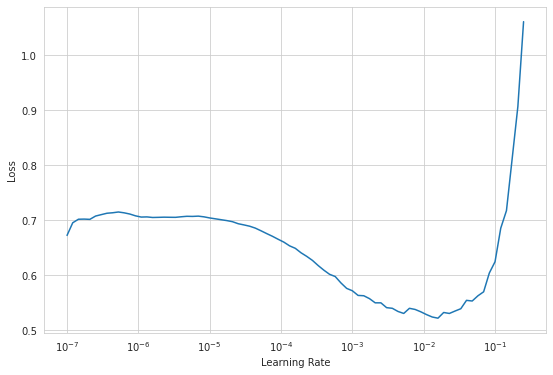

In [40]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [41]:
lr = lr_min; lr_min

0.0015848932787775993

In [42]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(3, lr_max=lr, cbs=fit_cbs)
# learn.fit_flat_cos(10, lr_max=lr_min, cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.168486,0.155435,0.934602,0.804283,0.770992,0.848515,0.877299,0.370000,02:22
1,0.153509,0.146990,0.939615,0.811844,0.789343,0.851485,0.876826,0.440000,02:24
2,0.132835,0.132184,0.945724,0.833176,0.812711,0.856931,0.892555,0.420000,02:24


Better model found at epoch 0 with fbeta_score value: 0.8042828113453949.
Better model found at epoch 1 with fbeta_score value: 0.8118437616295804.
Better model found at epoch 2 with fbeta_score value: 0.8331762373100515.


(1.318256749982538e-07, 6.309573450380412e-07)

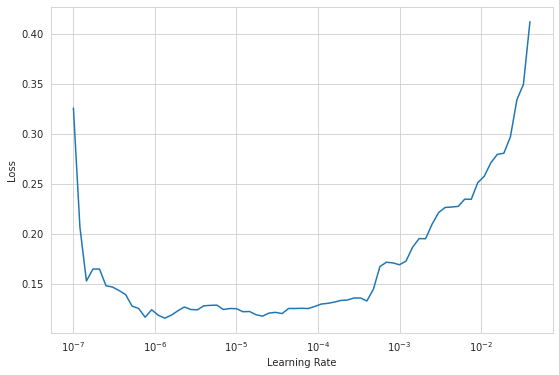

In [43]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [44]:
lr = lr_min; lr_min

1.318256749982538e-07

In [45]:
set_seed(TL_RAND_SEED)
learn.fit_one_cycle(5, lr_max=slice(lr/10, lr), cbs=fit_cbs)
# learn.fit_one_cycle(5, lr_max=lr, cbs=fit_cbs)
# learn.fit_flat_cos(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.102287,0.132144,0.945724,0.833176,0.812711,0.856931,0.892555,0.420000,04:29
1,0.107820,0.132186,0.946272,0.833188,0.817696,0.851485,0.891054,0.450000,04:30
2,0.132479,0.132188,0.946272,0.833290,0.817853,0.851485,0.891054,0.450000,04:31
3,0.124759,0.132197,0.947917,0.833202,0.835123,0.834158,0.886776,0.510000,04:31
4,0.119587,0.132205,0.947917,0.833202,0.835123,0.834158,0.886776,0.510000,04:31


Better model found at epoch 1 with fbeta_score value: 0.8331875840897877.
Better model found at epoch 2 with fbeta_score value: 0.8332897640866728.


In [46]:
learn.loss_func.thresh # => not part of pytorch BCE loss function (so added above as needed)

0.5099999999999998

In [49]:
learn.save(f"exp_{train_config['m_pre']}{train_config['base_model_name']}{train_config['m_suf']}")

Path('data/classification/sentiment/models/exp_verbatim_sent_multilabel_hf.pth')

Look at results

In [50]:
# have to add in the optimize threshold cb since its used as *not* associated to the learner
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate(cbs=[fit_cbs[-1]]))); scores

{'valid_loss': 0.13218766450881958,
 'accuracy_multi': 0.9462719559669495,
 'fbeta_score': 0.8332897640866728,
 'precision_score': 0.8178526389382393,
 'recall_score': 0.8514851485148515,
 'roc_auc_score': 0.8910536040304924,
 'opt_th': 0.44999999999999984}

In [51]:
learn = learn.load(f"exp_{train_config['save_model_filename']}")
learn.loss_func.thresh = scores['opt_th']
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Validation Loss: 0.13218767940998077


In [52]:
# learn.show_results(learner=learn, max_n=2) 
# => ERROR:Only one class present in y_true. ROC AUC score is not defined in that case.

Export model for inference

In [53]:
learn.export(fname=f"exp_{train_config['export_filename']}")

In [54]:
inf_learn = load_learner(f"{train_config['learner_path']}/exp_{train_config['export_filename']}")

In [55]:
inf_learn.loss_func.thresh = scores['opt_th']
inf_learn.loss_func.thresh

0.44999999999999984

In [56]:
inf_learn.blurr_predict('We are not paid enough and the benefits are horrible')

[(((#2) ['is_very_negative','is_negative'],),
  (#1) [tensor([False, False,  True,  True, False, False, False, False])],
  (#1) [tensor([0.0023, 0.0106, 0.6160, 0.9877, 0.0087, 0.0036, 0.0123, 0.0048])])]

In [57]:
inf_learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued")

[(((#2) ['is_very_positive','is_positive'],),
  (#1) [tensor([ True,  True, False, False, False, False, False, False])],
  (#1) [tensor([4.8965e-01, 9.9483e-01, 8.0672e-04, 3.3609e-03, 3.2918e-03, 3.5107e-04,
        2.0393e-04, 2.7630e-03])])]

## Review

In [58]:
#hide
try: del learn; del inf_learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [59]:
# predictions for a single model using the learner's model and data loaders
set_seed(TL_RAND_SEED)
learn, fit_cbs = get_learner(hf_model, 
                             dls, 
                             train_df=train_df, 
                             use_weighted_loss=False, 
                             use_fp16=True,
                             train_config_updates={})

learn = learn.load(f"exp_{train_config['save_model_filename']}")
learn.loss_func.thresh = scores['opt_th']
learn.model.cuda(1)
probs, targs  = learn.get_preds()

probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(torch.Size([1596, 8]), torch.Size([1596, 8]), 1596, 8, 0.44999999999999984)

### Lets look at validation metrics

In [60]:
# determine optimal threshold based on desired f-score
average, sample_weight = train_config['opt_beta_average'], train_config['opt_beta_sample_weight']
    
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [61]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

(0.49000000000000005, 0.45000000000000007, 0.15000000000000002)

In [62]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

(0.8294257164594904, 0.8332897640866728, 0.8791029167231923)

In [63]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f1), beta=1, 
                      average=average, sample_weight=sample_weight, zero_division=False)
res

0.8332897640866728

In [64]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9469768404960632, 0.9462719559669495, 0.9234022498130798)

In [65]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f1).byte() == targs.byte()).float().mean()
preds.item()

0.9462719559669495

### Overall metrics

In [66]:
eval_targs = targs.flatten()
eval_probs = probs.flatten()

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, **"Overall, how often is the classifier correct?"**

In [67]:
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match ALL the corresponding set of labels in y_true.
print(skm.accuracy_score(targs, (probs > threshold_f1), sample_weight=sample_weight))

0.6522556390977443


In [68]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f1).float(), sample_weight=sample_weight))

0.9462719298245614


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, **"What would the accuracy be by always predicting the most frequent case?"**

In [69]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 10748


In [70]:
most_freq_class_count / len(eval_targs)

0.8417919799498746

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [71]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f1).float(), 
                            weights=None, sample_weight=sample_weight))

0.8017127749627552


#### Confusion Matrix

Describes the performance of a classification model

In [72]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [73]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f1).float(), sample_weight=sample_weight)

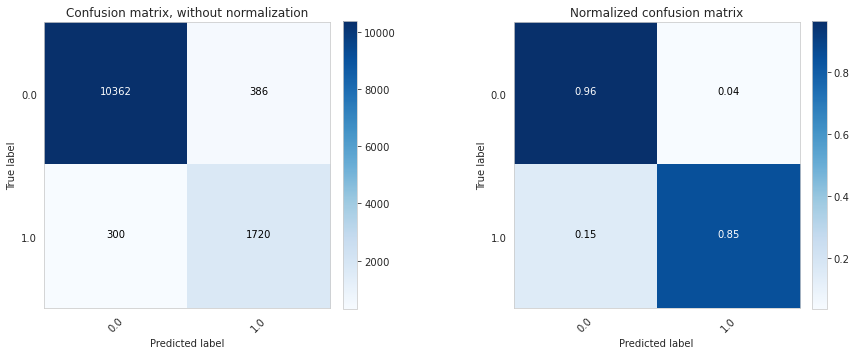

In [74]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [75]:
cm = skm.multilabel_confusion_matrix(targs, (probs > threshold_f1).float(), sample_weight=sample_weight)

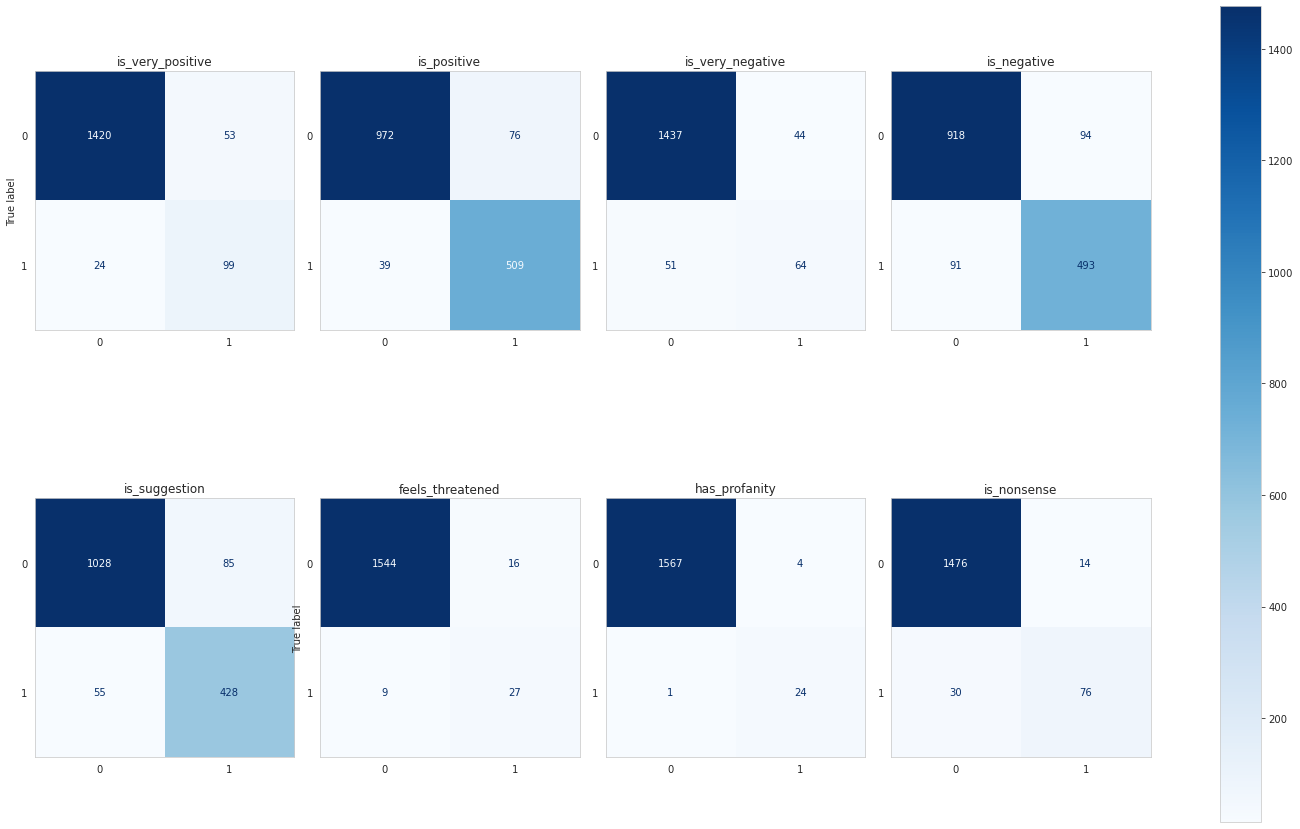

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay

f, axes = plt.subplots(2, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(8):
    disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g', cmap=plt.cm.Blues)
    disp.ax_.set_title(SENT_LABELS[1:][i][:30])
    disp.ax_.grid(False)
    if i<20:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.10)
f.colorbar(disp.im_, ax=axes)
plt.show()

In [77]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f1).float(), 
                                labels=[0,1], 
                                sample_weight=sample_weight, 
                                zero_division=1))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     10748
           1       0.82      0.85      0.83      2020

    accuracy                           0.95     12768
   macro avg       0.89      0.91      0.90     12768
weighted avg       0.95      0.95      0.95     12768



In [78]:
classification_report = skm.classification_report(targs, (probs > threshold_f1).float(), 
                                target_names=SENT_LABELS[1:],
                                sample_weight=sample_weight,
                                zero_division=1,
                                output_dict=True)

pd.DataFrame(classification_report).transpose()

,precision,recall,f1-score,support
is_very_positive,0.651316,0.804878,0.720000,123.0
is_positive,0.870085,0.928832,0.898500,548.0
is_very_negative,0.592593,0.556522,0.573991,115.0
is_negative,0.839864,0.844178,0.842015,584.0
is_suggestion,0.834308,0.886128,0.859438,483.0
feels_threatened,0.627907,0.750000,0.683544,36.0
has_profanity,0.857143,0.960000,0.905660,25.0
is_nonsense,0.844444,0.716981,0.775510,106.0
micro avg,0.816714,0.851485,0.833737,2020.0
macro avg,0.764707,0.805940,0.782332,2020.0


#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [79]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

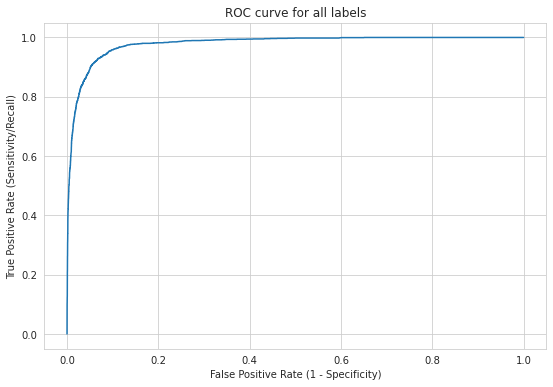

In [80]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [81]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.9786791786268318


### Let's look at things by label by label


In [82]:
label_metrics = {
    'thresholds': { 'f-beta05': threshold_f05, 'f-beta1': threshold_f1, 'f-beta2': threshold_f2 }
}

for idx, lbl in enumerate(SENT_LABELS[1:]):
    lbl_name, lbl_idx, lbl_targs, lbl_probs = lbl, idx, targs[:,idx], probs[:, idx]
    
    label_metrics[lbl_name] = {}
    label_metrics[lbl_name]['accuracies'] = {}
    label_metrics[lbl_name]['cohen_kappas'] = {}
    label_metrics[lbl_name]['confusion_matrices'] = {}
    label_metrics[lbl_name]['roc'] = {}
    label_metrics[lbl_name]['report'] = {}
    
    # get null accuracy (accuracy we'd get if we simply predicted the most common class)
    u_classes, u_counts = np.unique(lbl_targs, return_counts=True)
    most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
    label_metrics[lbl_name]['null_accuracy'] = most_freq_class_count / len(lbl_targs)
    
    # get raw probability distribution
    label_metrics[lbl_name]['probability_distribution'] = np.histogram(lbl_probs)
    
    # roc/auc curve metrics
    label_metrics[lbl_name]['roc_auc'] = skm.roc_auc_score(lbl_targs, lbl_probs, 
                                                           average=average, sample_weight=sample_weight)
    
    fpr, tpr, thresholds = skm.roc_curve(lbl_targs, lbl_probs, sample_weight=sample_weight)
    label_metrics[lbl_name]['roc']['fpr'] = fpr
    label_metrics[lbl_name]['roc']['tpr'] = tpr
    label_metrics[lbl_name]['roc']['thresholds'] = thresholds
    
    for k,v in label_metrics['thresholds'].items():
        label_metrics[lbl_name]['accuracies'][k] = skm.accuracy_score(lbl_targs, (lbl_probs > v), 
                                                                      sample_weight=sample_weight)
        
        label_metrics[lbl_name]['cohen_kappas'][k] = skm.cohen_kappa_score(lbl_targs, (lbl_probs > v), 
                                                                           sample_weight=sample_weight)
        
        label_metrics[lbl_name]['confusion_matrices'][k] = skm.confusion_matrix(lbl_targs, (lbl_probs > v), 
                                                                                sample_weight=sample_weight)
        
        precision, recall, fbeta_score, support = skm.precision_recall_fscore_support(lbl_targs, 
                                                                                      (lbl_probs > v), 
                                                                                      average=None, 
                                                                                      sample_weight=sample_weight)
        label_metrics[lbl_name]['report'][k] = {}
        label_metrics[lbl_name]['report'][k]['precision'] = precision
        label_metrics[lbl_name]['report'][k]['recall'] = recall
        label_metrics[lbl_name]['report'][k]['fbeta_score'] = fbeta_score
        label_metrics[lbl_name]['report'][k]['support'] = support
          
          

In [83]:
# label_metrics

IS_VERY_POSITIVE

Null Accuracy:	0.9229323308270677
AUC Score:	0.9752040799430397

		f-beta05(0.49)		f-beta1(0.45)		f-beta2(0.15)
Accuracy:	0.9517543859649122	0.9517543859649122	0.9179197994987469	
Cohen's Kappa:	0.6832745716583164	0.693923906871096	0.5960727036676403	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9801              0.9674              0.9737              1473                
1                   0.662               0.7642              0.7094              123                 
avg/total           0.821               0.8658              0.8416              1596                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9834              0.964               0.9736              1473                
1                   0.6513              0.8049              0.72                1

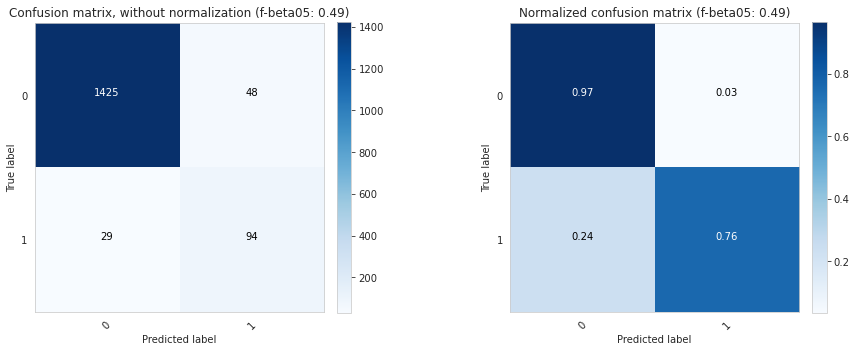

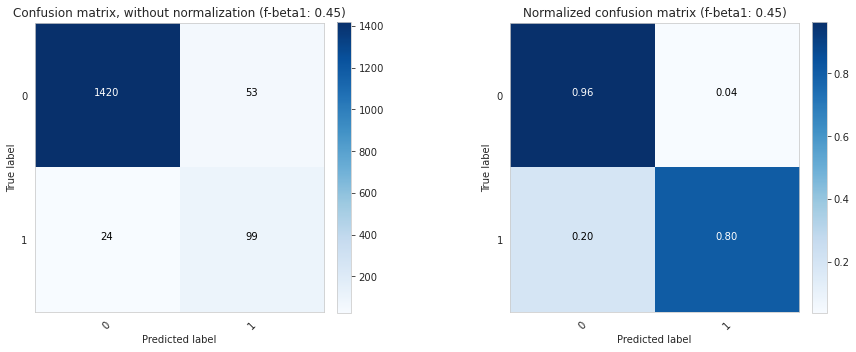

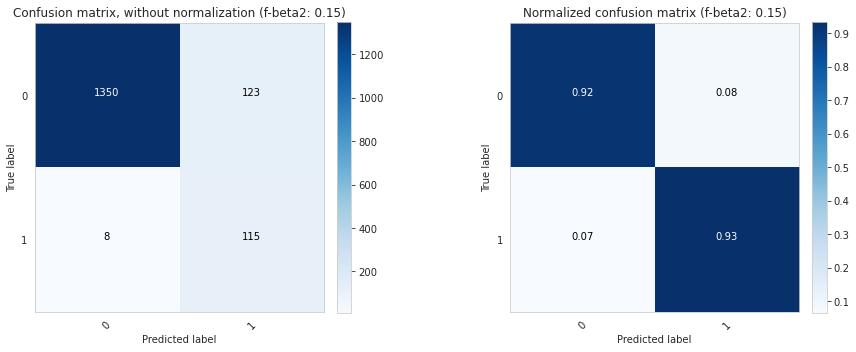



ROC Curve:


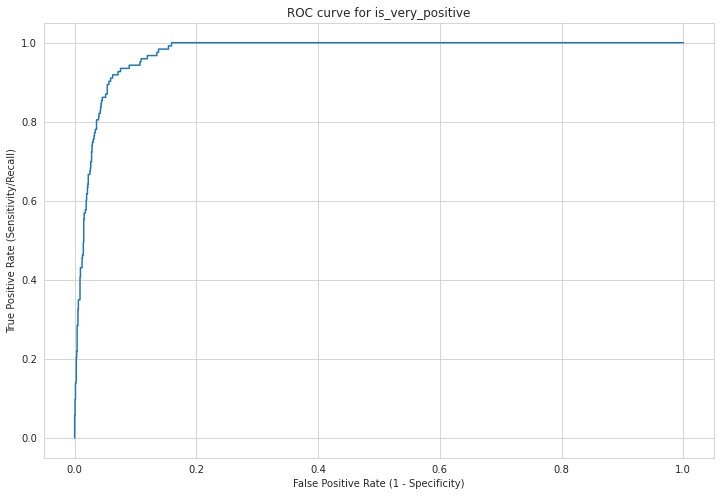

Predicted Probability Distribution:


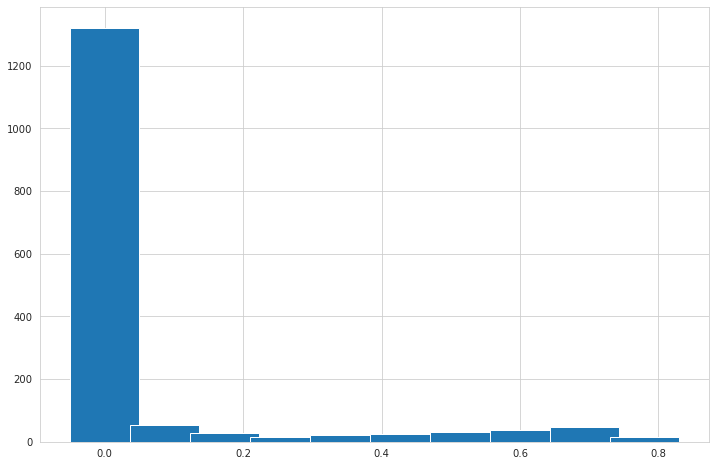



----------------------------------------------------------------------------------------------------


IS_POSITIVE

Null Accuracy:	0.656641604010025
AUC Score:	0.9750593762188666

		f-beta05(0.49)		f-beta1(0.45)		f-beta2(0.15)
Accuracy:	0.9266917293233082	0.9279448621553885	0.9122807017543859	
Cohen's Kappa:	0.839316139291701	0.8427394894045795	0.8140491741066971	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9559              0.9313              0.9435              1048                
1                   0.8748              0.9179              0.8958              548                 
avg/total           0.9154              0.9246              0.9196              1596                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9614              0.9275              0.9441              104

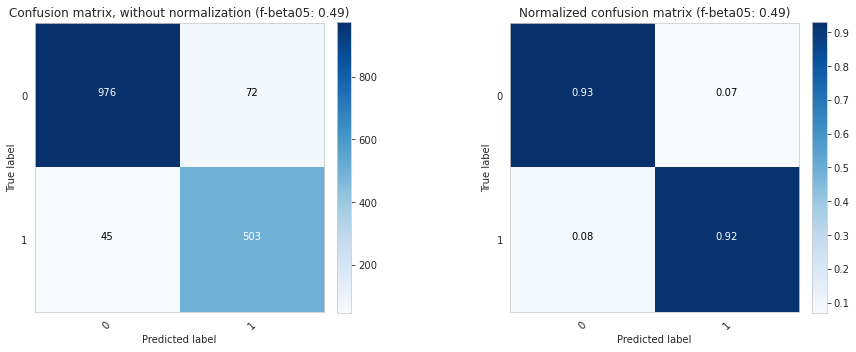

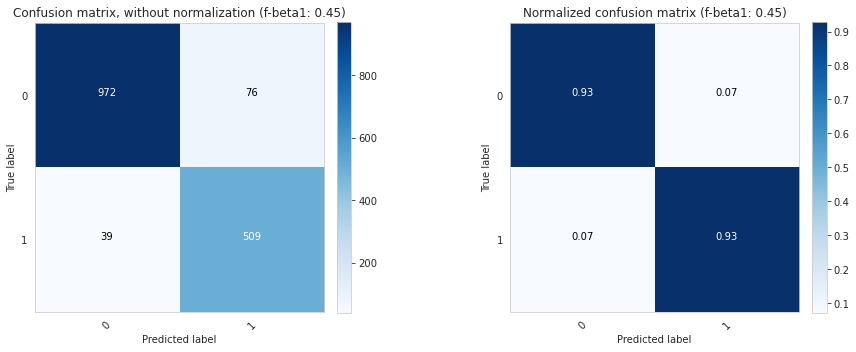

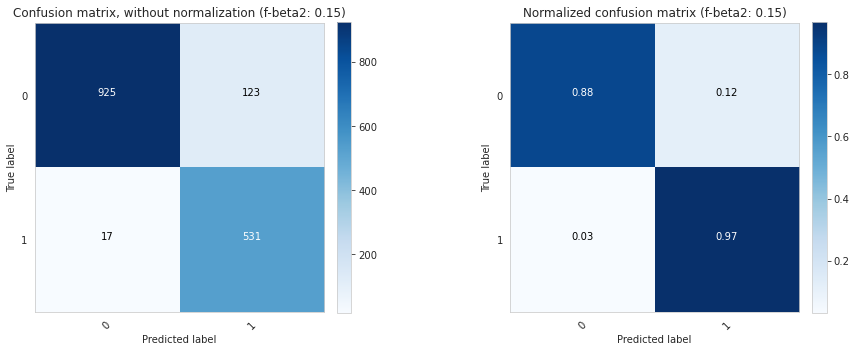



ROC Curve:


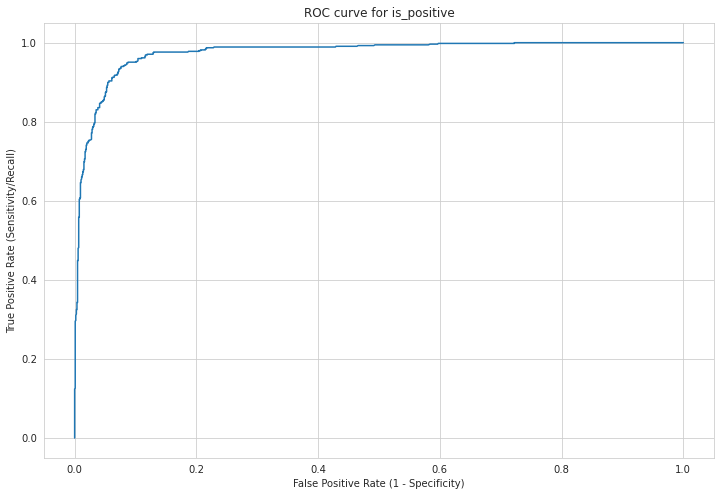

Predicted Probability Distribution:


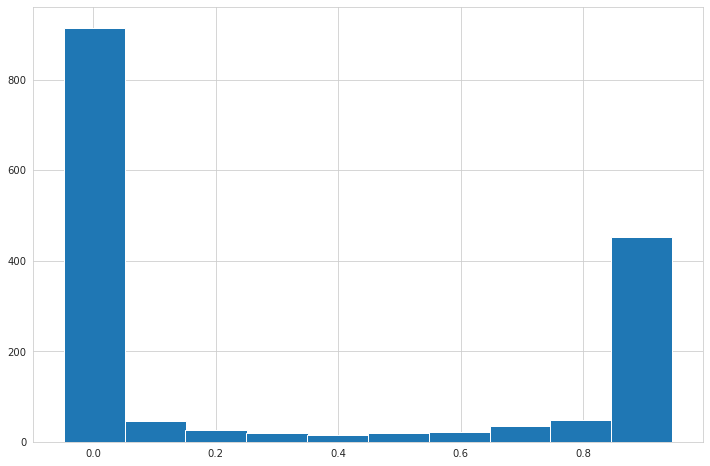



----------------------------------------------------------------------------------------------------


IS_VERY_NEGATIVE

Null Accuracy:	0.9279448621553885
AUC Score:	0.9500631183395474

		f-beta05(0.49)		f-beta1(0.45)		f-beta2(0.15)
Accuracy:	0.9429824561403509	0.9404761904761905	0.8972431077694235	
Cohen's Kappa:	0.5344164337188726	0.542027619703505	0.48679055869054577	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9627              0.9764              0.9695              1481                
1                   0.6277              0.513               0.5646              115                 
avg/total           0.7952              0.7447              0.767               1596                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9657              0.9703              0.968           

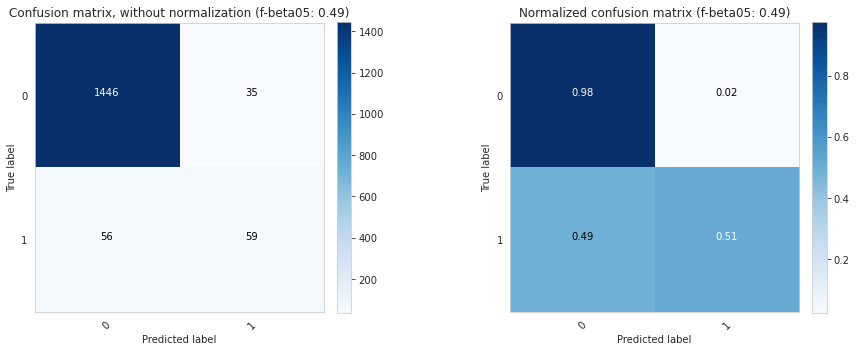

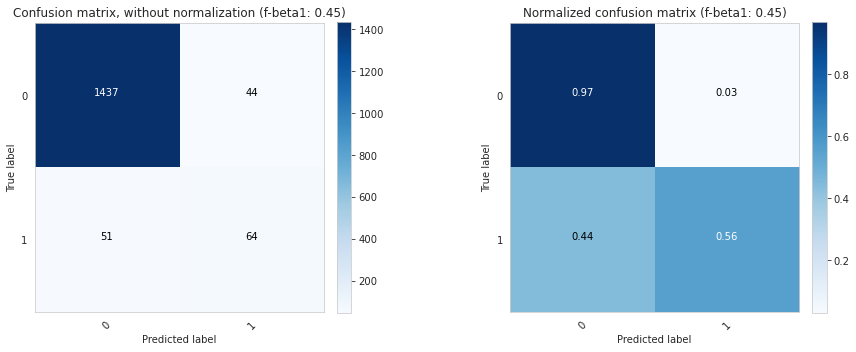

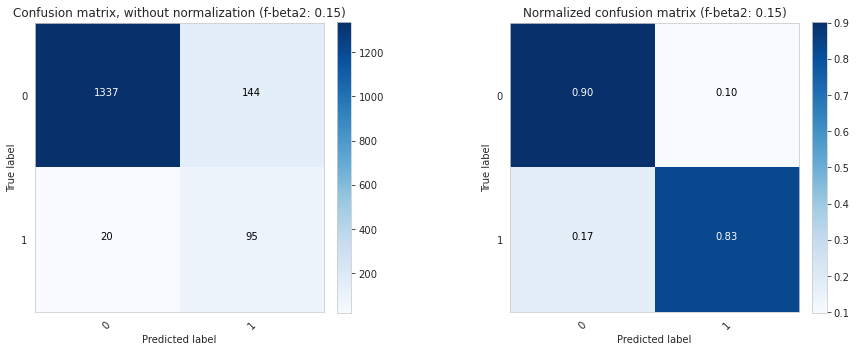



ROC Curve:


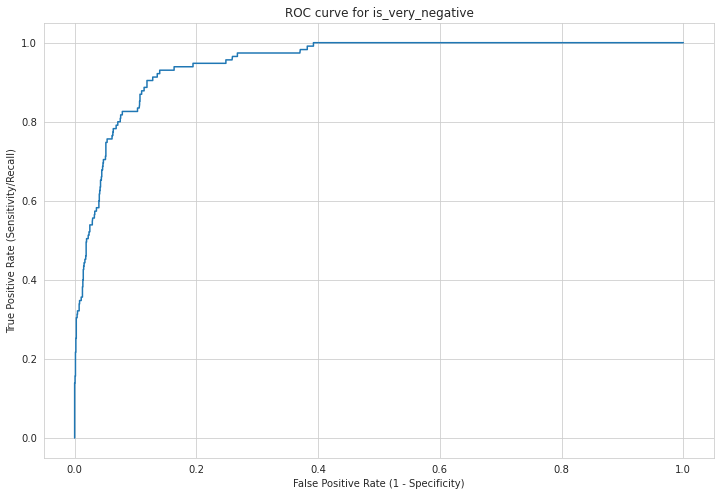

Predicted Probability Distribution:


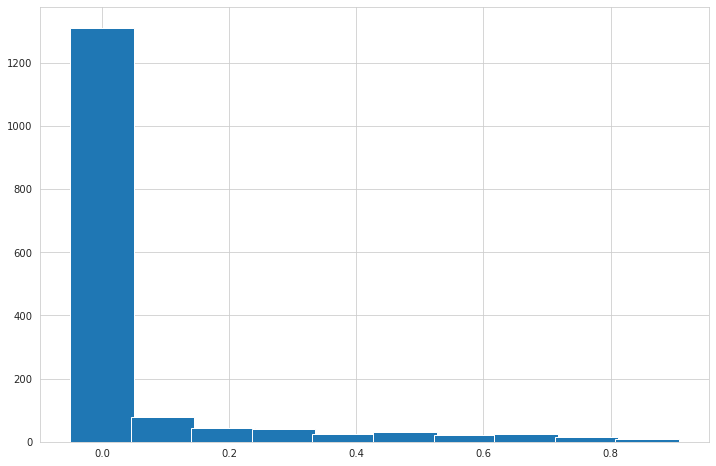



----------------------------------------------------------------------------------------------------


IS_NEGATIVE

Null Accuracy:	0.6340852130325815
AUC Score:	0.9533669594997022

		f-beta05(0.49)		f-beta1(0.45)		f-beta2(0.15)
Accuracy:	0.8878446115288221	0.8840852130325815	0.8283208020050126	
Cohen's Kappa:	0.7575176291246379	0.7504774782388236	0.6591614810011348	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9079              0.916               0.912               1012                
1                   0.8522              0.839               0.8456              584                 
avg/total           0.8801              0.8775              0.8788              1596                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9098              0.9071              0.9085              1

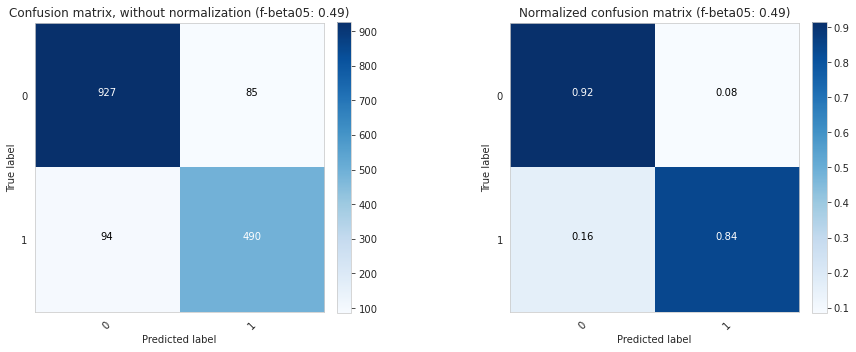

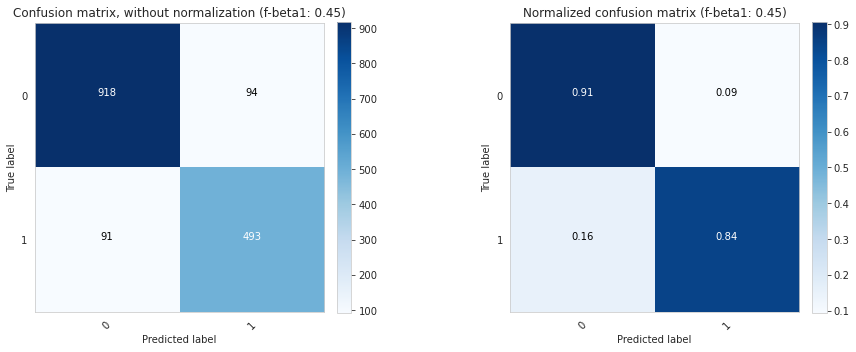

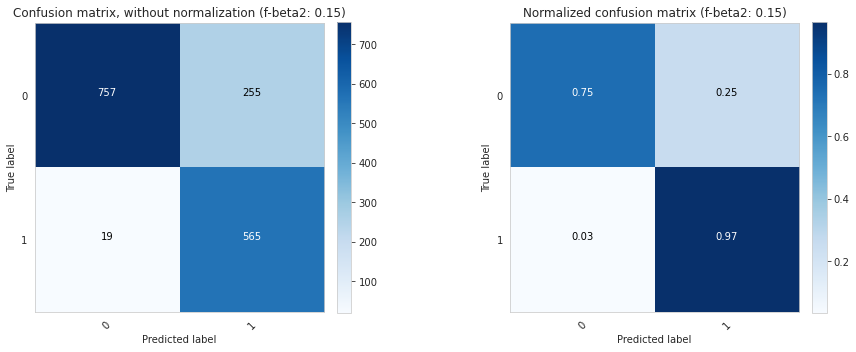



ROC Curve:


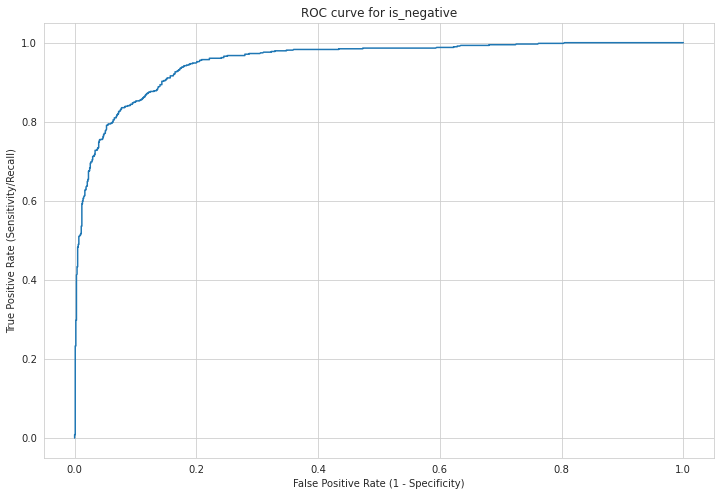

Predicted Probability Distribution:


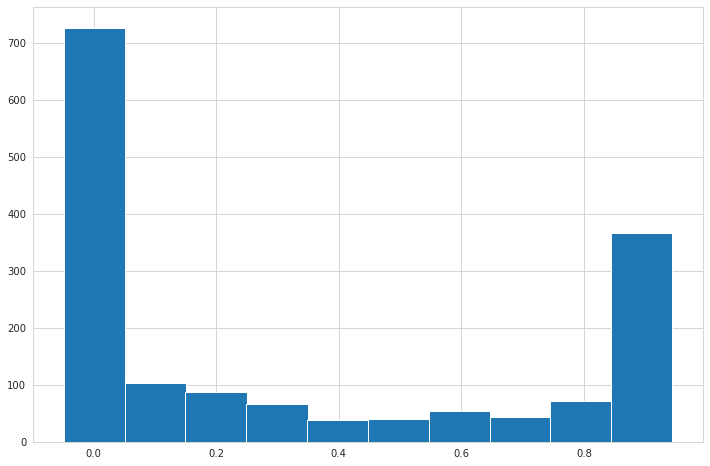



----------------------------------------------------------------------------------------------------


IS_SUGGESTION

Null Accuracy:	0.6973684210526315
AUC Score:	0.9659854644619674

		f-beta05(0.49)		f-beta1(0.45)		f-beta2(0.15)
Accuracy:	0.9122807017543859	0.9122807017543859	0.8922305764411027	
Cohen's Kappa:	0.7941096791671505	0.7957695113056164	0.7609276125681261	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9435              0.9299              0.9367              1113                
1                   0.8437              0.8716              0.8574              483                 
avg/total           0.8936              0.9008              0.897               1596                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9492              0.9236              0.9362             

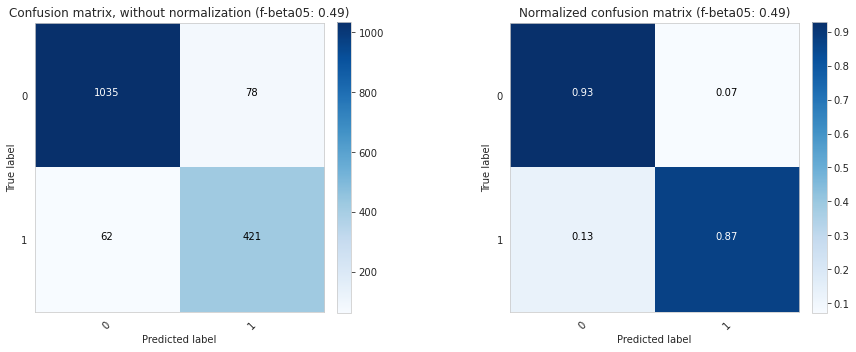

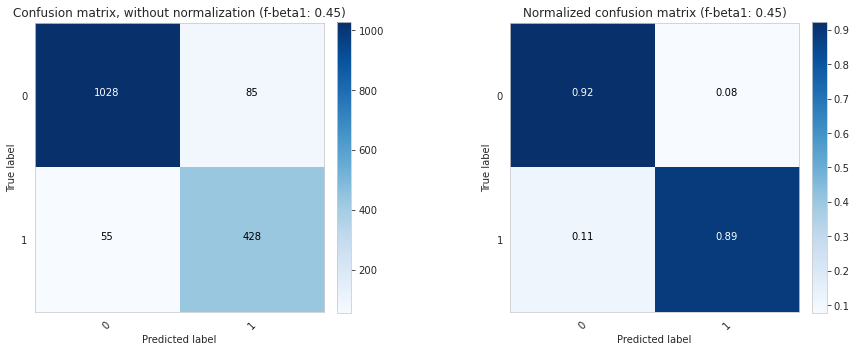

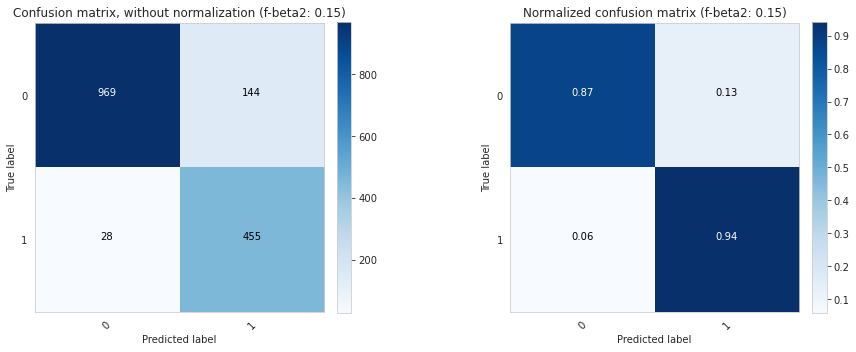



ROC Curve:


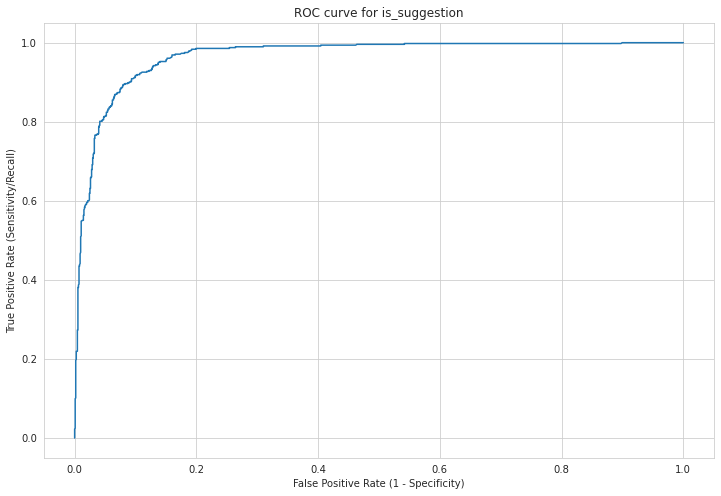

Predicted Probability Distribution:


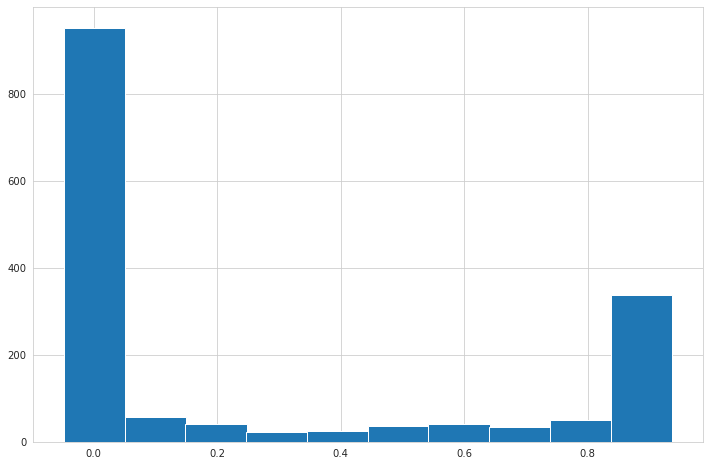



----------------------------------------------------------------------------------------------------


FEELS_THREATENED

Null Accuracy:	0.9774436090225563
AUC Score:	0.988034188034188

		f-beta05(0.49)		f-beta1(0.45)		f-beta2(0.15)
Accuracy:	0.9849624060150376	0.9843358395989975	0.9774436090225563	
Cohen's Kappa:	0.6846473029045643	0.6755781051809933	0.5976470588235294	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9942              0.9904              0.9923              1560                
1                   0.6429              0.75                0.6923              36                  
avg/total           0.8185              0.8702              0.8423              1596                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9942              0.9897              0.992            

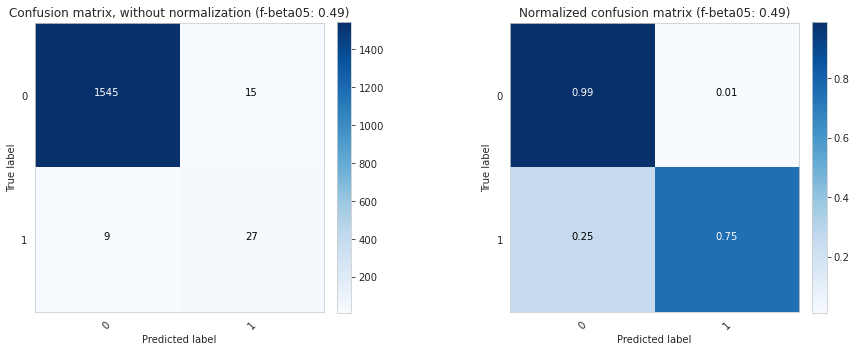

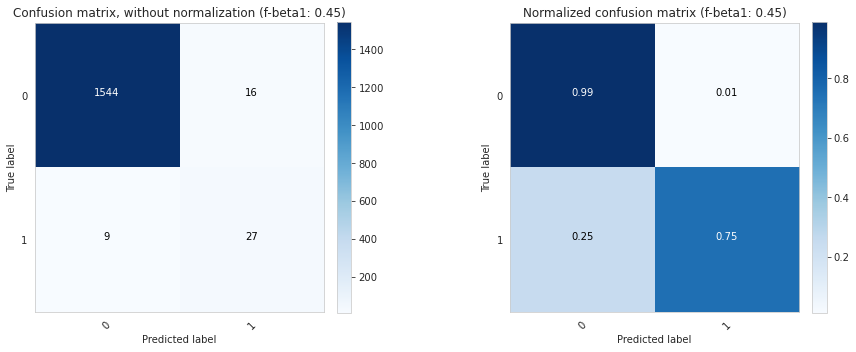

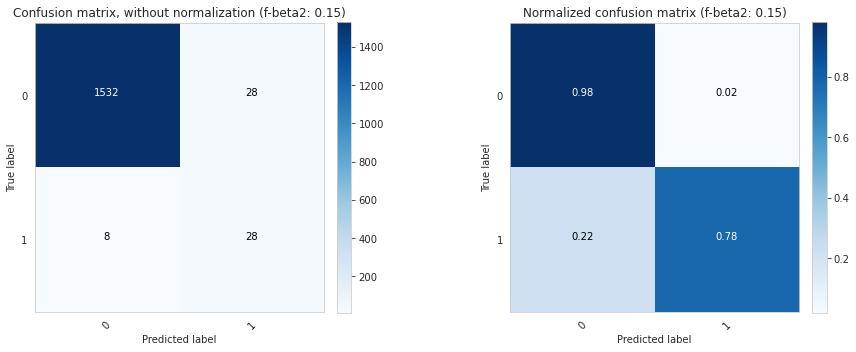



ROC Curve:


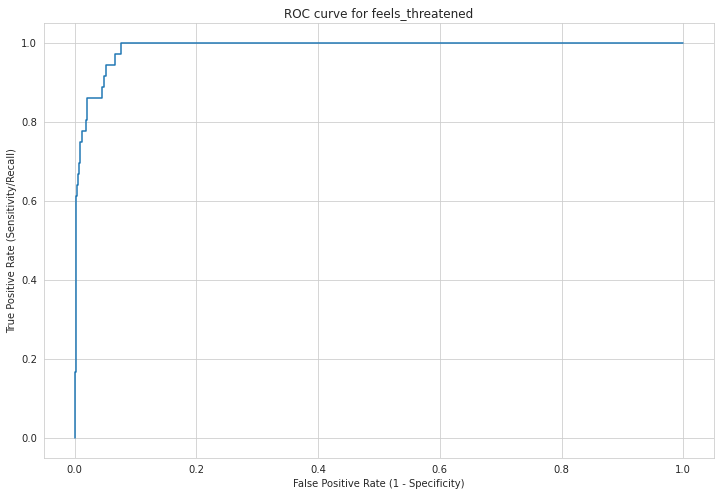

Predicted Probability Distribution:


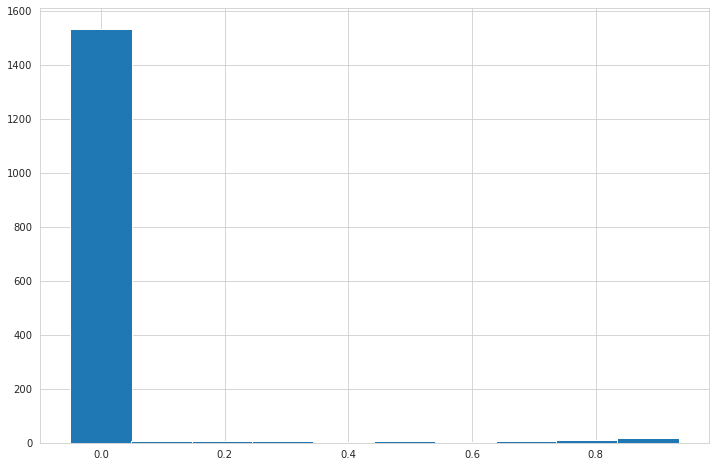



----------------------------------------------------------------------------------------------------


HAS_PROFANITY

Null Accuracy:	0.9843358395989975
AUC Score:	0.9996690006365372

		f-beta05(0.49)		f-beta1(0.45)		f-beta2(0.15)
Accuracy:	0.9968671679197995	0.9968671679197995	0.9949874686716792	
Cohen's Kappa:	0.9040727027936721	0.9040727027936721	0.8595657625552695	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9994              0.9975              0.9984              1571                
1                   0.8571              0.96                0.9057              25                  
avg/total           0.9283              0.9787              0.952               1596                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9994              0.9975              0.9984             

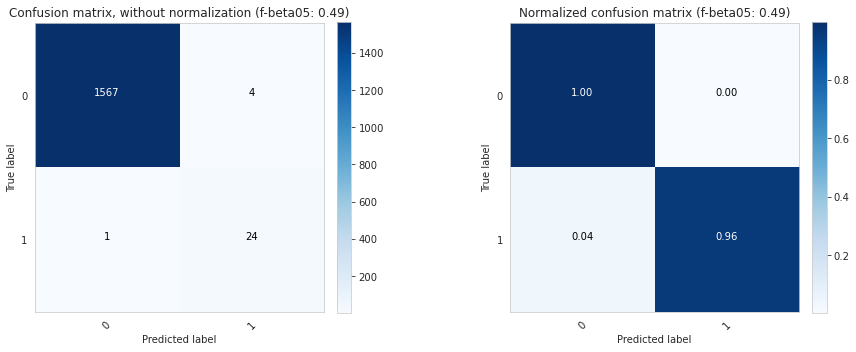

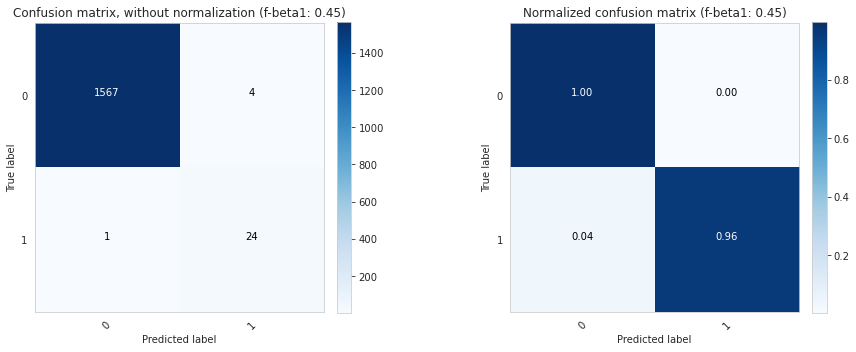

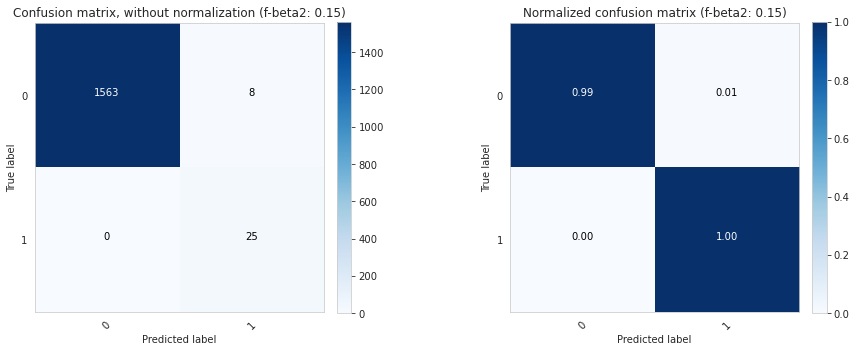



ROC Curve:


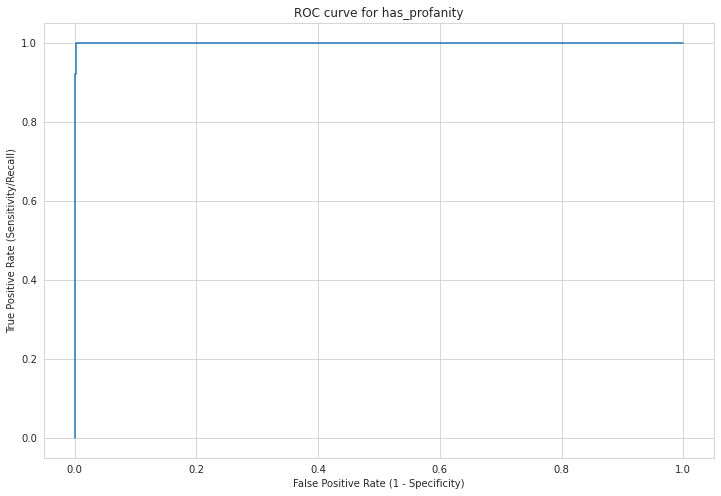

Predicted Probability Distribution:


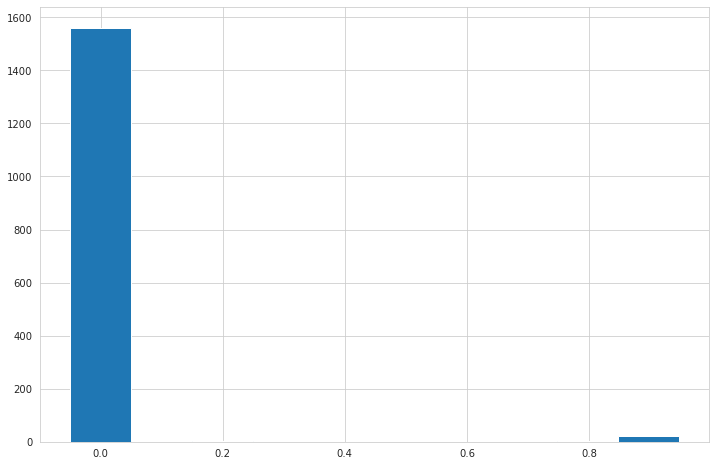



----------------------------------------------------------------------------------------------------


IS_NONSENSE

Null Accuracy:	0.9335839598997494
AUC Score:	0.9515892110928201

		f-beta05(0.49)		f-beta1(0.45)		f-beta2(0.15)
Accuracy:	0.9724310776942355	0.9724310776942355	0.9667919799498746	
Cohen's Kappa:	0.7586538725908003	0.7609281804068959	0.7466454209996645	

Classification Reports:
f-beta05
                    precision           recall              fbeta_score         support             
0                   0.9794              0.9913              0.9853              1490                
1                   0.8523              0.7075              0.7732              106                 
avg/total           0.9159              0.8494              0.8793              1596                

f-beta1
                    precision           recall              fbeta_score         support             
0                   0.9801              0.9906              0.9853              1

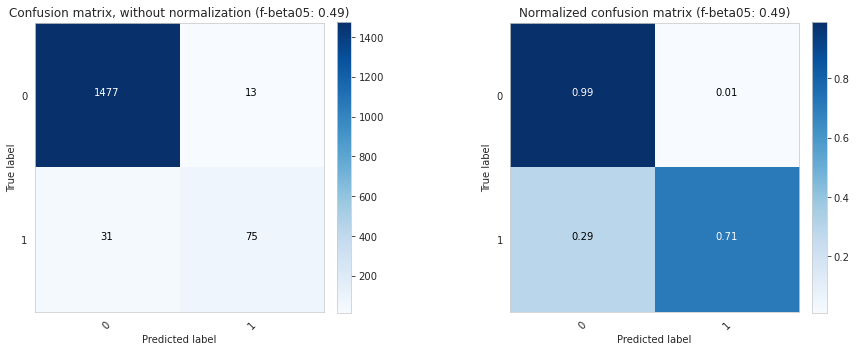

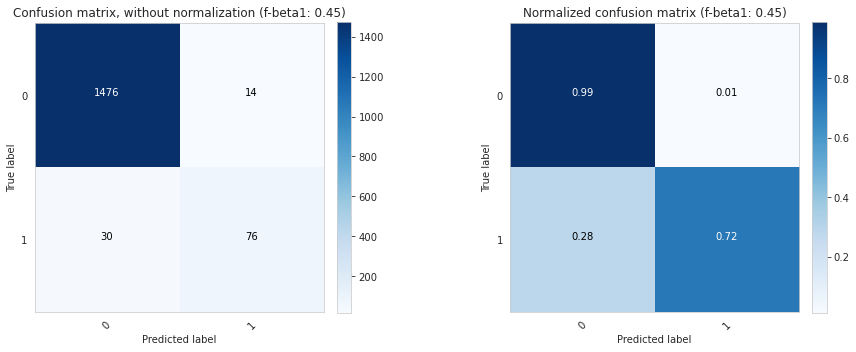

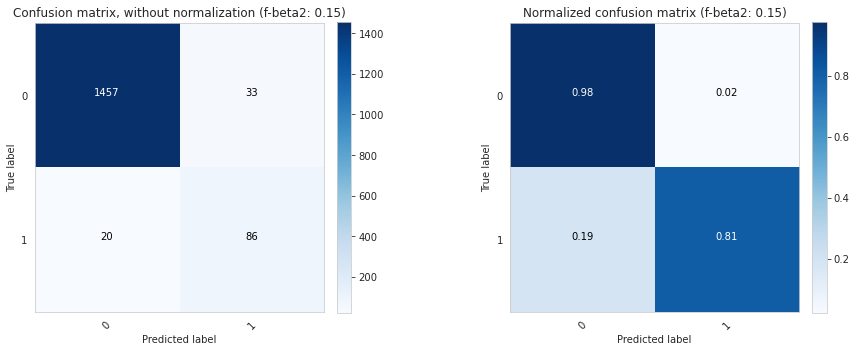



ROC Curve:


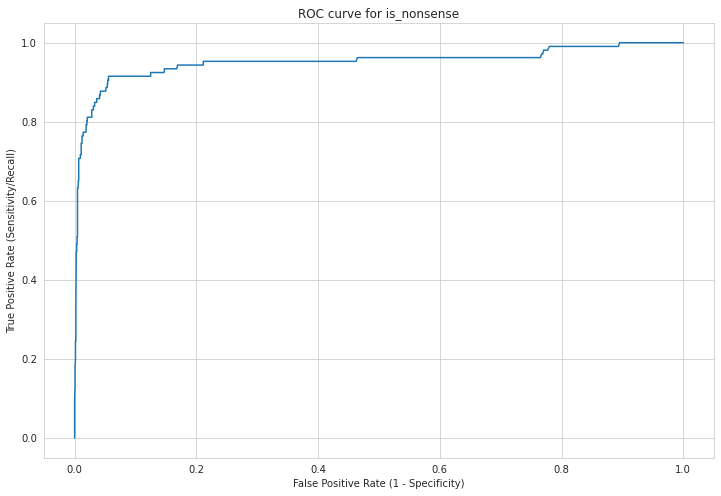

Predicted Probability Distribution:


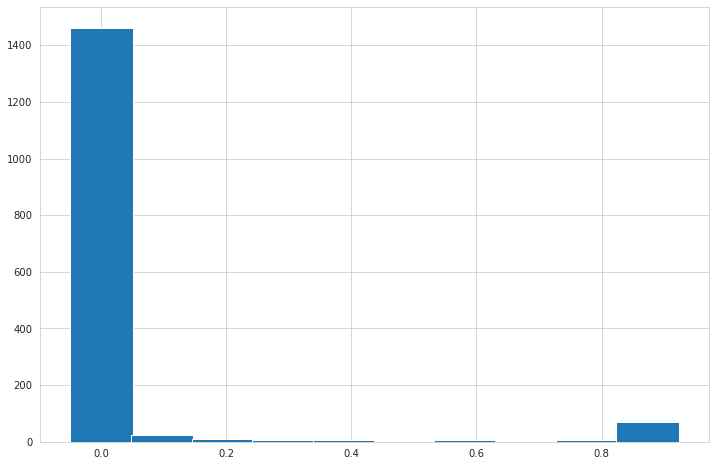



----------------------------------------------------------------------------------------------------




In [84]:
for lbl in label_metrics.keys():
    if (lbl == 'thresholds'): continue
    
    print(f'{lbl.upper()}\n')
    
    print(f'Null Accuracy:\t{label_metrics[lbl]["null_accuracy"]}')
    print(f'AUC Score:\t{label_metrics[lbl]["roc_auc"]}')
    print('')
    
    print(''.join([ f'\t\t{threshold}({np.round(v, 4)})' for threshold, v in label_metrics['thresholds'].items() ]))
    
    print('Accuracy:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["accuracies"][threshold]}\t', end='')
    print('')
    
    print('Cohen\'s Kappa:\t', end='')
    for threshold, v in label_metrics['thresholds'].items():
        print(f'{label_metrics[lbl]["cohen_kappas"][threshold]}\t', end='')
    print('\n')
    
    print('Classification Reports:')
    for k in label_metrics[lbl]['report'].keys():
        print(f'{k}')
        print(f'{"":<20}' + ''.join([ f'{sub_key:<20}' for sub_key in label_metrics[lbl]['report'][k].keys() ]))
        
        for i in range(2):
            print(f'{i:<20}' + ''.join([ f'{np.round(v[i],4):<20}' 
                                      for v in label_metrics[lbl]['report'][k].values() ]))
        
        print(f'{"avg/total":<20}' + ''.join([ f'{ np.round(v.mean(),4) if (sub_key != "support") else np.round(v.sum(),4):<20}' 
                                     for sub_key, v in label_metrics[lbl]['report'][k].items() ]))
        print('')
    print('\n')
    
    print('Confusion Matrices:')
    for threshold, v in label_metrics['thresholds'].items():
        cm = label_metrics[lbl]['confusion_matrices'][threshold]
        
        # Plot non-normalized confusion matrix
        fig = plt.figure(figsize=(12,8))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(cm, classes=[0,1], 
                              title=f'Confusion matrix, without normalization ({threshold}: {np.round(v,4)})')

        # Plot normalized confusion matrix
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(cm, classes=[0,1], normalize=True, 
                              title=f'Normalized confusion matrix ({threshold}: {np.round(v,4)})')

        fig.subplots_adjust(wspace=0.5)
        plt.show()
    print('\n')
    
    print('ROC Curve:')
    plt.figure(figsize=(12,8))
    plt.plot(label_metrics[lbl]['roc']['fpr'], label_metrics[lbl]['roc']['tpr'])
    plt.xlim = ([0.0, 1.0])
    plt.ylim = ([0.0, 1.0])
    plt.title(f'ROC curve for {lbl}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity/Recall)')
    plt.grid(True)
    plt.show()
    
    print('Predicted Probability Distribution:')
    plt.figure(figsize=(12,8))
    plt.xlim = ([0.0, 1.0])
    plt.bar(label_metrics[lbl]['probability_distribution'][1][:-1], 
            label_metrics[lbl]['probability_distribution'][0], width=0.1)
    plt.show()
    
    print('\n')
    print('-'*100)
    print('\n')
        

## Final results


In [85]:
#hide
try: del inf_learn
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [86]:
inf_learn = load_learner(fname=f"{train_config['learner_path']}/exp_{train_config['export_filename']}")
inf_learn.loss_func.thresh = scores['opt_th']
dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, train_config_updates={})
inf_learn.dls = dls

In [87]:
# inf_learn.loss_func = inf_learn.loss_func.to('cuda:1')

In [88]:
probs, targs, loss = inf_learn.get_preds(with_loss=True, reorder=True)
probs.shape, targs.shape, loss.shape

(torch.Size([1596, 8]), torch.Size([1596, 8]), torch.Size([1596]))

In [89]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [90]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

print(threshold_f05, threshold_f1, threshold_f2)

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs, targs, sigmoid=False)}')

0.49000000000000005 0.4600000000000001 0.19
Fowards Only
-------------
f05:	Optimal threshold = 0.49000000000000005	(Accuracy = 0.9468985199928284)
f1:	Optimal threshold = 0.4600000000000001	(Accuracy = 0.946506917476654)
f2:	Optimal threshold = 0.19	(Accuracy = 0.9311560392379761)

Accuracy: 0.9474467635154724


In [91]:
final_valid_loss = loss.mean().item(); final_valid_loss

0.13213272392749786

## Build our training loop for hyperparam optimization and final training

In [92]:
#hide
try: del learn; del dls
except: pass
finally: gc.collect(); torch.cuda.empty_cache()

In [93]:
#export
def train(params, trial=None, yyyymmdd = datetime.today().strftime("%Y%m%d"), train_config_updates={}):
    
    config = {**train_config, **train_config_updates}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'

    # 1. grab our huggingface objects
    task = HF_TASKS_AUTO.SequenceClassification
    hf_config = AutoConfig.from_pretrained(params["pretrained_model_name"])
    hf_config.num_labels = len(SENT_LABELS[1:])
    
    if (f'{params["pretrained_model_name"]}_config_overrides' in params):
        hf_config.update(params[f'{params["pretrained_model_name"]}_config_overrides'])
    else:
        config_overrides = { k:v for k,v in params.items() if (k in hf_config.to_dict()) }
        hf_config.update(config_overrides)

    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(params["pretrained_model_name"], 
                                                                                   task=task, 
                                                                                   config=hf_config)

    # 2. build our dls and learner
    df = get_train_data(train_config_updates=config)
    train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]
    
    set_seed(TL_RAND_SEED)
    dls = get_train_dls(df, hf_arch, hf_config, hf_tokenizer, hf_model, train_config_updates=config, use_cache=False)
    
    set_seed(TL_RAND_SEED)
    learn, fit_cbs = get_learner(hf_model, 
                                 dls, 
                                 train_df=None, 
                                 use_weighted_loss=params["use_weighted_loss"], 
                                 use_fp16=params["use_fp16"],
                                 add_save_model_cb=params['save_model'],
                                 train_config_updates=config)
    
    if (trial is not None): learn.add_cb(FastAIPruningCallbackv2(trial=trial, monitor=params['optimize_for']))
    
    # 3. train
    with learn.no_logging(): 
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_frozen_epochs"], lr_max=params["frozen_lr"], cbs=fit_cbs)
        
        learn.unfreeze()
        set_seed(TL_RAND_SEED)
        learn.fit_one_cycle(params["n_unfrozen_epochs"], 
                            lr_max=slice(params["unfrozen_lr_min"], params["unfrozen_lr_max"]), 
                            cbs=fit_cbs)
        
        # export model for inference (SavedModelCallback already saves the best model if save_mode=True)
        if (trial is None): learn.export(fname=f"{yyyymmdd}_{config['export_filename']}")
        
    # 4. evaluate
    scores = dict(zip(learn.recorder.metric_names[2:], learn.validate(cbs=[fit_cbs[-1]])))
    
    try:
        if (trial is not None): return scores[params['optimize_for']]
        
        learn.loss_func.thresh = scores['opt_th']
        probs, targs, losses = learn.get_preds(dl=dls.valid, with_loss=True)

        # determine optimal threshold based on desired f-score
        average, sample_weight = config['opt_beta_average'], config['opt_beta_sample_weight']

        f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)
        f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                           average=average, sample_weight=sample_weight)

        scores['f05'], scores['f1'], scores['f2'] = {}, {}, {}

        scores['f05']['threshold'] = f05.opt_th(probs, targs)
        scores['f1']['threshold'] = f1.opt_th(probs, targs)
        scores['f2']['threshold'] = f2.opt_th(probs, targs)

        scores['f05']['score'] = f05.opt_fscore(probs, targs)
        scores['f1']['score'] = f1.opt_fscore(probs, targs)
        scores['f2']['score'] = f2.opt_fscore(probs, targs)

        # save scores from validation set if mode == training
        with open(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json", 'w') as f:
            json.dump(scores, f, indent=4)

        # save train/validation probs, targs, losses for review
        test_dl = dls.test_dl(df, with_labels=True)
        probs, targs, losses = learn.get_preds(dl=test_dl, with_loss=True)

        probs_df = pd.DataFrame(probs.numpy(), columns=['prob_' + lbl for lbl in SENT_LABELS[1:]])
        targs_df = pd.DataFrame(targs.numpy(), columns= ['targ_' + lbl for lbl in SENT_LABELS[1:]])
        losses_df = pd.DataFrame(losses.numpy(), columns=['loss'])
        final_df = pd.concat([df.reset_index(), probs_df, targs_df, losses_df], axis=1)

        final_df.to_csv(f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_results.csv", index=False)
        return scores, final_df
    
    finally:
        # cleanup
        del learn; del dls 
        del hf_arch; del hf_config; del hf_tokenizer; del hf_model

### Hyperparameter optimization

In [94]:
#export
def after_trial_cleanup(study, trial):
    gc.collect()
    torch.cuda.empty_cache()

In [95]:
#export
def objective(trial, yyyymmdd = datetime.today().strftime("%Y%m%d"), train_config_updates={}):
    opt_params = {
        'pretrained_model_name': trial.suggest_categorical("pretrained_model_name", ["facebook/bart-base"]),
        
        'save_model': trial.suggest_categorical("save_model", [True, False]), 
        'use_weighted_loss': trial.suggest_categorical("use_weighted_loss", [False]),
        'use_fp16': trial.suggest_categorical("use_fp16", [True]),
        'n_frozen_epochs': trial.suggest_int("n_frozen_epochs", 1, 3),
        'n_unfrozen_epochs': trial.suggest_int("n_unfrozen_epochs", 0, 5),
        'frozen_lr': trial.suggest_loguniform("frozen_lr", 3e-4, 3e-2),
        'unfrozen_lr_max': trial.suggest_loguniform("unfrozen_lr_max", 5e-6, 5e-5),
        'unfrozen_lr_min': trial.suggest_loguniform("unfrozen_lr_min", 5e-8, 5e-6),
        'optimize_for': 'fbeta_score',
        
        'facebook/bart-base_config_overrides': {
            'activation_dropout': trial.suggest_discrete_uniform('activation_dropout', 0.0, 0.3, 0.05),
            'attention_dropout': trial.suggest_discrete_uniform('attention_dropout', 0.0, 0.3, 0.05),
            'classif_dropout': trial.suggest_discrete_uniform('classif_dropout', 0.0, 0.3, 0.05),
            'dropout': trial.suggest_discrete_uniform('dropout', 0.0, 0.3, 0.05)
        },
        'roberta-base_config_overrides': {
            'attention_probs_dropout_prob': trial.suggest_discrete_uniform('attention_probs_dropout_prob', 0.0, 0.3, 0.05),
            'hidden_dropout_prob': trial.suggest_discrete_uniform('hidden_dropout_prob', 0.0, 0.3, 0.05)
        }
    }
    
    score = train(opt_params, trial=trial, yyyymmdd=yyyymmdd, train_config_updates=train_config_updates)
    return score

In [96]:
yyyymmdd = datetime.today().strftime("%Y%m%d")

In [97]:
start = datetime.now()

pruner = optuna.pruners.MedianPruner() if True else optuna.pruners.NopPruner()
study = optuna.create_study(direction="maximize", pruner=pruner)

train_config_updates = {}
study.optimize(partial(objective, yyyymmdd=yyyymmdd, train_config_updates=train_config_updates), 
               n_trials=30, 
               callbacks=[after_trial_cleanup])#, timeout=600)

end = datetime.now()

[I 2021-03-04 12:15:36,574] A new study created in memory with name: no-name-ae5ceb8b-1dca-45da-a11e-452bf1411513


Better model found at epoch 0 with fbeta_score value: 0.6270595956220515.
Better model found at epoch 1 with fbeta_score value: 0.7755353701062215.


[I 2021-03-04 12:20:59,524] Trial 0 finished with value: 0.7755353701062215 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': True, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 0, 'frozen_lr': 0.004872238034174011, 'unfrozen_lr_max': 3.658167190036626e-05, 'unfrozen_lr_min': 8.559827480904983e-08, 'activation_dropout': 0.25, 'attention_dropout': 0.05, 'classif_dropout': 0.05, 'dropout': 0.25, 'attention_probs_dropout_prob': 0.05, 'hidden_dropout_prob': 0.05}. Best is trial 0 with value: 0.7755353701062215.


[I 2021-03-04 12:28:16,555] Trial 1 finished with value: 0.800228501618195 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 1, 'frozen_lr': 0.0019570055758345644, 'unfrozen_lr_max': 8.115116508614504e-06, 'unfrozen_lr_min': 2.9847825845962596e-07, 'activation_dropout': 0.25, 'attention_dropout': 0.15000000000000002, 'classif_dropout': 0.1, 'dropout': 0.3, 'attention_probs_dropout_prob': 0.0, 'hidden_dropout_prob': 0.15000000000000002}. Best is trial 1 with value: 0.800228501618195.


[I 2021-03-04 12:37:57,853] Trial 2 finished with value: 0.836491680957046 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 1, 'frozen_lr': 0.0016420112114205242, 'unfrozen_lr_max': 4.9212880503767394e-05, 'unfrozen_lr_min': 4.591697085208433e-07, 'activation_dropout': 0.05, 'attention_dropout': 0.1, 'classif_dropout': 0.3, 'dropout': 0.05, 'attention_probs_dropout_prob': 0.2, 'hidden_dropout_prob': 0.0}. Best is trial 2 with value: 0.836491680957046.


[I 2021-03-04 12:54:00,143] Trial 3 finished with value: 0.8428498023708615 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 3, 'frozen_lr': 0.00036155496862247687, 'unfrozen_lr_max': 4.4444250015701986e-05, 'unfrozen_lr_min': 1.0241915824425453e-06, 'activation_dropout': 0.15000000000000002, 'attention_dropout': 0.2, 'classif_dropout': 0.3, 'dropout': 0.15000000000000002, 'attention_probs_dropout_prob': 0.25, 'hidden_dropout_prob': 0.05}. Best is trial 3 with value: 0.8428498023708615.


[I 2021-03-04 13:01:13,997] Trial 4 finished with value: 0.825289054845504 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 1, 'frozen_lr': 0.003320662356481103, 'unfrozen_lr_max': 5.600438956894135e-06, 'unfrozen_lr_min': 8.053252891367231e-07, 'activation_dropout': 0.2, 'attention_dropout': 0.0, 'classif_dropout': 0.3, 'dropout': 0.05, 'attention_probs_dropout_prob': 0.0, 'hidden_dropout_prob': 0.0}. Best is trial 3 with value: 0.8428498023708615.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-04 13:03:58,696] Trial 5 pruned. Trial was pruned at epoch 0.


[I 2021-03-04 13:06:44,196] Trial 6 pruned. Trial was pruned at epoch 0.


[I 2021-03-04 13:22:30,036] Trial 7 pruned. Trial was pruned at epoch 2.


[I 2021-03-04 13:25:14,138] Trial 8 pruned. Trial was pruned at epoch 0.


[I 2021-03-04 13:27:58,996] Trial 9 pruned. Trial was pruned at epoch 0.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-04 13:30:42,123] Trial 10 pruned. Trial was pruned at epoch 0.


[I 2021-03-04 13:35:46,679] Trial 11 pruned. Trial was pruned at epoch 1.


[I 2021-03-04 13:40:56,372] Trial 12 pruned. Trial was pruned at epoch 1.


[I 2021-03-04 13:46:06,207] Trial 13 pruned. Trial was pruned at epoch 1.


/home/wgilliam/anaconda3/envs/tritonlytics-ai/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2021-03-04 13:48:50,860] Trial 14 pruned. Trial was pruned at epoch 0.


[I 2021-03-04 13:54:00,263] Trial 15 pruned. Trial was pruned at epoch 1.


[I 2021-03-04 14:05:40,144] Trial 16 finished with value: 0.8375183428971132 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 2, 'frozen_lr': 0.000340690989288696, 'unfrozen_lr_max': 2.203055691038797e-05, 'unfrozen_lr_min': 1.5283399431534193e-06, 'activation_dropout': 0.05, 'attention_dropout': 0.05, 'classif_dropout': 0.2, 'dropout': 0.05, 'attention_probs_dropout_prob': 0.15000000000000002, 'hidden_dropout_prob': 0.0}. Best is trial 3 with value: 0.8428498023708615.


[I 2021-03-04 14:17:10,403] Trial 17 pruned. Trial was pruned at epoch 1.


[I 2021-03-04 14:28:39,087] Trial 18 pruned. Trial was pruned at epoch 1.


[I 2021-03-04 14:40:09,567] Trial 19 pruned. Trial was pruned at epoch 1.


[I 2021-03-04 14:51:34,819] Trial 20 pruned. Trial was pruned at epoch 1.


[I 2021-03-04 14:56:45,806] Trial 21 pruned. Trial was pruned at epoch 1.


[I 2021-03-04 15:10:47,103] Trial 22 finished with value: 0.8393256256144133 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 2, 'n_unfrozen_epochs': 2, 'frozen_lr': 0.0013042536620798777, 'unfrozen_lr_max': 4.2030904082270374e-05, 'unfrozen_lr_min': 4.853093581590304e-07, 'activation_dropout': 0.05, 'attention_dropout': 0.05, 'classif_dropout': 0.25, 'dropout': 0.0, 'attention_probs_dropout_prob': 0.15000000000000002, 'hidden_dropout_prob': 0.05}. Best is trial 3 with value: 0.8428498023708615.


[I 2021-03-04 15:22:07,263] Trial 23 pruned. Trial was pruned at epoch 1.


[I 2021-03-04 15:24:50,006] Trial 24 pruned. Trial was pruned at epoch 0.


[I 2021-03-04 15:27:32,627] Trial 25 pruned. Trial was pruned at epoch 0.


[I 2021-03-04 15:39:02,033] Trial 26 pruned. Trial was pruned at epoch 1.


[I 2021-03-04 15:41:44,731] Trial 27 pruned. Trial was pruned at epoch 0.


[I 2021-03-04 15:53:22,753] Trial 28 finished with value: 0.8397215785411181 and parameters: {'pretrained_model_name': 'facebook/bart-base', 'save_model': False, 'use_weighted_loss': False, 'use_fp16': True, 'n_frozen_epochs': 1, 'n_unfrozen_epochs': 2, 'frozen_lr': 0.0005994458958250299, 'unfrozen_lr_max': 3.2017087294351254e-05, 'unfrozen_lr_min': 5.905484545781066e-07, 'activation_dropout': 0.05, 'attention_dropout': 0.0, 'classif_dropout': 0.25, 'dropout': 0.15000000000000002, 'attention_probs_dropout_prob': 0.15000000000000002, 'hidden_dropout_prob': 0.0}. Best is trial 3 with value: 0.8428498023708615.


[I 2021-03-04 15:56:05,951] Trial 29 pruned. Trial was pruned at epoch 0.


In [100]:
m_pre, m_suf = train_config['m_pre'], train_config['m_suf']
full_model_name = f"{m_pre}{train_config['base_model_name']}{m_suf}"
   
pruned_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED ]
complete_trials = [ t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE ]

print('Study statistics: ')
print('  Number of finished trials: ', len(study.trials))
print('  Number of pruned trials: ', len(pruned_trials))
print('  Number of complete trials: ', len(complete_trials))

print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items(): print('    {}: {}'.format(key, value))
print('  User attrs:')
for key, value in trial.user_attrs.items(): print('    {}: {}'.format(key, value))
    
best_params = study.best_params
best_params['fbeta_score'] = study.best_value

with open(f"{train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json", 'w') as f:
    json.dump(best_params, f, indent=4)

trials_df = study.trials_dataframe()
trials_df.to_csv(f"{train_config['learner_path']}/{yyyymmdd}_{full_model_name}_trial_results.csv", index=False)

print(f'total time is {(end - start).total_seconds()} seconds')

Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  22
  Number of complete trials:  8
Best trial:
  Value:  0.8428498023708615
  Params: 
    pretrained_model_name: facebook/bart-base
    save_model: False
    use_weighted_loss: False
    use_fp16: True
    n_frozen_epochs: 1
    n_unfrozen_epochs: 3
    frozen_lr: 0.00036155496862247687
    unfrozen_lr_max: 4.4444250015701986e-05
    unfrozen_lr_min: 1.0241915824425453e-06
    activation_dropout: 0.15000000000000002
    attention_dropout: 0.2
    classif_dropout: 0.3
    dropout: 0.15000000000000002
    attention_probs_dropout_prob: 0.25
    hidden_dropout_prob: 0.05
  User attrs:
total time is 13229.592258 seconds


### Training with best params

In [101]:
m_pre, m_suf = train_config['m_pre'], train_config['m_suf']
full_model_name = f"{m_pre}{train_config['base_model_name']}{m_suf}"

In [102]:
with open(f"{train_config['learner_path']}/{yyyymmdd}_{full_model_name}_best_trial_params.json") as f: 
    best_params = json.load(f)
    
train_yyyymmdd = datetime.today().strftime("%Y%m%d")
scores, train_res_df = train(params=best_params, yyyymmdd=train_yyyymmdd, train_config_updates={})

In [103]:
scores

{'valid_loss': 0.13250146806240082,
 'accuracy_multi': 0.9504229426383972,
 'fbeta_score': 0.8431665752389367,
 'precision_score': 0.8404013895595986,
 'recall_score': 0.8485148514851485,
 'roc_auc_score': 0.8950481807840723,
 'opt_th': 0.5099999999999998,
 'f05': {'threshold': 0.49000000000000005, 'score': 0.8374586120559782},
 'f1': {'threshold': 0.49000000000000005, 'score': 0.8427775871170751},
 'f2': {'threshold': 0.19, 'score': 0.8801877913256723}}

In [104]:
train_res_df.head()

,index,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,overall_sentiment,is_very_positive,is_positive,is_very_negative,is_negative,is_suggestion,feels_threatened,has_profanity,is_nonsense,labels,is_valid,_text_,prob_is_very_positive,prob_is_positive,prob_is_very_negative,prob_is_negative,prob_is_suggestion,prob_feels_threatened,prob_has_profanity,prob_is_nonsense,targ_is_very_positive,targ_is_positive,targ_is_very_negative,targ_is_negative,targ_is_suggestion,targ_feels_threatened,targ_has_profanity,targ_is_nonsense,loss
0,0,72661,1877,The major area of concern for me is the communication between the divisions/department and the p...,NaN,English,110,9,SAW,UCSD,179154,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1.0,90860.0,3659,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,90800.0,MEDICINE,90860.0,CARDIOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,0,0,1,0,0,0,0,is_negative,False,The major area of concern for me is the communication between the divisions/department and the p...,0.002003,0.010170,0.042088,0.907804,0.710829,0.005060,0.000078,0.002463,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.175039
1,1,162330,8475,"First and foremost, there needs to be more parking spots. FOR UNDERGRADUATE STUDENTS - not visit...",NaN,English,132,7,CSS-STUDENT-ONLY,UCSD,190733,Parking,Let us know your suggestions on how to improve Campus Parking,Verbatim-Dept-Improve,9.0,Parking-Improve,Campus Parking,Parking & Transportation,Parking & Transportation,"Parking, Commuter Services",1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,0,0,1,1,0,0,0,is_negative is_suggestion,False,"First and foremost, there needs to be more parking spots. FOR UNDERGRADUATE STUDENTS - not visit...",0.004486,0.005598,0.417925,0.952662,0.889721,0.007374,0.004298,0.000925,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.091155
2,2,120812,1896,"leak on the wall for a long time, just repaired, left a big hole on the wall~",NaN,English,53,7,CSS-STUDENT-ONLY,UCSD,106894,Housing,Any additional comments for HOUSING SERVICES?,Verbatim-Dept-Question,11.0,Housing-Comments,Housing Maintenance and Custodial,Facilities,"Building, Custodial, Facilities Maintenance",Facilities Maintenance,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,0,0,1,0,0,0,0,is_negative,False,"leak on the wall for a long time, just repaired, left a big hole on the wall~",0.000863,0.013902,0.032961,0.920074,0.026912,0.001094,0.004265,0.014842,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.022410
3,3,179737,1895,I don't understand why a shuttle has to sit there and wait for the next shuttle to come when it ...,NaN,English,63,7,CSS-STUDENT-ONLY,UCSD,113569,Shuttle,Any additional comments for SHUTTLE SERVICES?,Verbatim-Dept-Question,10.0,Shuttle Services-Comments,Shuttle Services,Parking & Transportation,Parking & Transportation,"Parking, Commuter Services",1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,0,0,1,0,0,0,0,is_negative,False,I don't understand why a shuttle has to sit there and wait for the next shuttle to come when it ...,0.001160,0.004628,0.387806,0.977586,0.030792,0.001478,0.044266,0.008577,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.075728
4,4,150374,27613,"Ran into connectivity issues in

In [105]:
# load scores
with open(f"{train_config['learner_path']}/{train_yyyymmdd}_{full_model_name}_train_scores.json") as f: 
    training_results = json.load(f)
    
training_results

{'valid_loss': 0.13250146806240082,
 'accuracy_multi': 0.9504229426383972,
 'fbeta_score': 0.8431665752389367,
 'precision_score': 0.8404013895595986,
 'recall_score': 0.8485148514851485,
 'roc_auc_score': 0.8950481807840723,
 'opt_th': 0.5099999999999998,
 'f05': {'threshold': 0.49000000000000005, 'score': 0.8374586120559782},
 'f1': {'threshold': 0.49000000000000005, 'score': 0.8427775871170751},
 'f2': {'threshold': 0.19, 'score': 0.8801877913256723}}

In [106]:
inf_learn = load_learner(f"{train_config['learner_path']}/{train_yyyymmdd}_{full_model_name}_export.pkl")
inf_learn.loss_func.thresh = scores['opt_th']

print(inf_learn.loss_func.thresh)
print(inf_learn.blurr_predict('We are not paid enough and the benefits are horrible'))
print(inf_learn.blurr_predict("The faculty really support us well!!!  It's great working and I feel valued"))

0.5099999999999998
[((['is_very_negative', 'is_negative'],), [tensor([False, False,  True,  True, False, False, False, False])], [tensor([0.0032, 0.0118, 0.6215, 0.9867, 0.0078, 0.0019, 0.0126, 0.0043])])]
[((['is_very_positive', 'is_positive'],), [tensor([ True,  True, False, False, False, False, False, False])], [tensor([6.9105e-01, 9.9204e-01, 2.7022e-03, 3.8792e-03, 3.0828e-03, 5.3462e-04,
        6.4680e-04, 1.9377e-03])])]


## Inference

### Inference (ad-hoc documents)

In [107]:
print(SENT_LABELS[1:])

['is_very_positive', 'is_positive', 'is_very_negative', 'is_negative', 'is_suggestion', 'feels_threatened', 'has_profanity', 'is_nonsense']


In [108]:
test_comments = [
    'Not paid enough.',
    'I am satisfied with my benefits and we have enough people in my department. The faculty is mean to me.',
    'I love cats',
    "I can never find a parking spot. The shuttles are not on time. Help",
    "I was really uncomfortable to express my opinion!!!",
    "Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\\r\\n\\r\\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation."
]

for c in test_comments: print(inf_learn.blurr_predict(c))

[((['is_negative'],), [tensor([False, False, False,  True, False, False, False, False])], [tensor([9.9391e-04, 1.6863e-02, 1.2417e-01, 9.6290e-01, 9.1533e-03, 5.5800e-04,
        2.6059e-03, 2.0803e-02])])]
[((['is_positive', 'is_negative'],), [tensor([False,  True, False,  True, False, False, False, False])], [tensor([3.1262e-02, 8.6422e-01, 9.6878e-02, 8.7742e-01, 7.6641e-03, 8.7848e-02,
        1.8422e-02, 8.2382e-04])])]
[((['is_positive'],), [tensor([False,  True, False, False, False, False, False, False])], [tensor([2.7279e-01, 9.8307e-01, 1.2999e-03, 3.4389e-03, 2.1808e-03, 2.9548e-04,
        1.2896e-03, 1.0315e-02])])]
[((['is_negative'],), [tensor([False, False, False,  True, False, False, False, False])], [tensor([1.8712e-03, 3.6729e-02, 2.1976e-01, 9.4723e-01, 3.8623e-01, 5.1856e-04,
        7.9325e-04, 3.1273e-03])])]
[((['is_negative', 'feels_threatened'],), [tensor([False, False, False,  True, False,  True, False, False])], [tensor([2.5214e-03, 1.2940e-02, 6.6182e-02, 9.

### Inference (batch)

In [109]:
#export
def get_preds(inf_df, yyyymmdd=None, learner_export_path=None, train_scores_path=None, 
              device=torch.device('cpu'), train_config_updates={}):
    
    config = {**train_config, **train_config_updates}    
    m_pre, m_suf, base_model_name = config['m_pre'], config['m_suf'], config['base_model_name']
    full_model_name = f'{m_pre}{base_model_name}{m_suf}'
    
    # 1. grab learner, procs, and data
    cpu = device.type == 'cpu'
    
    if (yyyymmdd is None and learner_export_path is None): 
        export_dir = Path(config['learner_path'])
        learner_export_path = sorted(export_dir.glob(f"[0-9]*_{config['export_filename']}"), reverse=True)[0]
        train_scores_path = export_dir/f"{learner_export_path.stem.split('_')[0]}_{full_model_name}_train_scores.json"
        
    if (learner_export_path is None): 
        learner_export_path = f"{config['learner_path']}/{yyyymmdd}_{config['export_filename']}"
        
    if (train_scores_path is None): 
        train_scores_path = f"{config['learner_path']}/{yyyymmdd}_{full_model_name}_train_scores.json"
        
    with open(train_scores_path) as f: training_results = json.load(f)
        
    inf_learn = load_learner(fname=learner_export_path, cpu=cpu)
    inf_learn.loss_func.thresh = training_results['opt_th']
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    inf_df = inf_df.copy()
    inf_df[config['txt_col']] = inf_df[config['orig_txt_col']]
    inf_df.dropna(subset=[config['txt_col']], inplace=True)
    inf_df.reset_index(drop=True, inplace=True)
    inf_dl = inf_learn.dls.test_dl(inf_df, rm_type_tfms=None, bs=16)

    # 3. get probs and document vectors
    test_probs = []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # note: even though there is no targets, each batch is a tuple!
            probs = torch.sigmoid(inf_learn.model(b[0])[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))

    all_probs = L(torch.cat(test_probs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. return results with scores in a df, probs, and labels
    prob_labels = ['prob_' + lbl for lbl in  SENT_LABELS[1:]]
    probs_df = pd.DataFrame(all_probs.numpy(), columns=prob_labels)
        
    final_df = pd.concat([inf_df, probs_df], axis=1)
    final_df.drop(columns=[config['txt_col']], inplace=True)
    
    for lbl in  SENT_LABELS[1:]:
        final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > training_results['opt_th']).astype(np.int64)
        
#     final_df['valid_loss'] = training_results['valid_loss']
#     final_df['accuracy_multi'] = training_results['accuracy_multi']
#     final_df['fbeta_score'] = training_results['fbeta_score']
#     final_df['precision_score'] = training_results['precision_score']
#     final_df['recall_score'] = training_results['recall_score']
#     final_df['roc_auc_score'] = training_results['roc_auc_score']
#     final_df['opt_th'] = training_results['opt_th']
#     final_df['f05_threshold'] = training_results['f05']['threshold']
#     final_df['f05_score'] = training_results['f05']['score']
#     final_df['f1_threshold'] = training_results['f1']['threshold']
#     final_df['f1_score'] = training_results['f1']['score']
#     final_df['f2_threshold'] = training_results['f2']['threshold']
#     final_df['f2_score'] = training_results['f2']['score']

    # cleanup
    try: del inf_learn; del inf_dl
    except: pass
    finally: gc.collect(); torch.cuda.empty_cache()
    
    return final_df, Path(learner_export_path).stem, training_results, SENT_LABELS[1:]

In [110]:
yyyymmdd = train_yyyymmdd

In [111]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 212].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)

print(len(verbatims_df), len(inf_df))

591447 4045


In [112]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

preds_df, model_name, train_res, inf_labels = get_preds(inf_df, device=device, yyyymmdd=yyyymmdd, 
                                                        train_config_updates={})

print(preds_df.shape, len(inf_labels))

cuda:1
0
(4045, 68) torch.Size([4045, 8]) 8


In [113]:
preds_df.head()

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,_text_,prob_is_very_positive,prob_is_positive,prob_is_very_negative,prob_is_negative,prob_is_suggestion,prob_feels_threatened,prob_has_profanity,prob_is_nonsense,pred_is_very_positive,pred_is_positive,pred_is_very_negative,pred_is_negative,pred_is_suggestion,pred_feels_threatened,pred_has_profanity,pred_is_nonsense,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,f05_threshold,f05_score,f1_threshold,f1_score,f2_threshold,f2_score
0,589996,2576,"no, I do not want to elaborate on my answers out fear of reprisal",NaN,English,212,9,SAW,UCSD,451417,EDI,If you would like to elaborate on any of your answers to the conduct and behavioral questions ab...,Verbatim,117.0,Conduct & Behavioral - Comments,EDI,None,None,None,1,17.0,3729,999999.0,UC San Diego,50000.0,VC-RESOURCE MANAGEMENT & PLANNING,802.0,FACILITIES MANAGEMENT,17.0,FLEET SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"no, I do not want to elaborate on my answers out fear of reprisal",0.000429,0.016381,0.001540,0.055005,0.003913,0.056982,0.000146,0.879814,0,0,0,0,0,0,0,1,0.132501,0.950423,0.843167,0.840401,0.848515,0.895048,0.51,0.49,0.837459,0.49,0.842778,0.19,0.880188
1,591624,9440,I would highlight Randy Leopold. He exemplifies the Mission Statement of UCSD and of our depart...,NaN,English,212,9,SAW,UCSD,449570,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,50712.0,4753,999999.0,UC San Diego,50000.0,VC-RESOURCE MANAGEMENT & PLANNING,50100.0,"CAPITAL PROGRAM MANAGEMENT, DESIGN & DEVELOPMENT SERVICES",50710.0,CAPITAL PROGRAM MANAGEMENT,50712.0,CAPITAL PROGRAM MANAGEMENT STAFF,NaN,NaN,NaN,NaN,NaN,NaN,I would highlight Randy Leopold. He exemplifies the Mission Statement of UCSD and of our depart...,0.714094,0.984793,0.003105,0.003454,0.002813,0.000869,0.000332,0.001524,1,1,0,0,0,0,0,0,0.132501,0.950423,0.843167,0.840401,0.848515,0.895048,0.51,0.49,0.837459,0.49,0.842778,0.19,0.880188
2,591691,9440,"Michelle Ghani, Medicine",NaN,English,212,9,SAW,UCSD,449814,None,Would you like to highlight a colleague or manager who has made a particular impact on creating ...,Verbatim,201.0,Highligh Colleague or Manager,Other,None,None,None,1,90894.0,3321,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,90800.0,MEDICINE,90894.0,REGENERATIVE MEDICINE,NaN,NaN,NaN,NaN,NaN,NaN,"Michelle Ghani, Medicine",0.004958,0.017998,0.000350,0.003416,0.004138,0.000434,0.000057,0.046090,0,0,0,0,0,0,0,0,0.132501,0.950423,0.843167,0.840401,0.848515,0.895048,0.51,0.49,0.837459,0.49,0.842778,0.19,0.880188
3,589378,1877,It has been said that we are paid accordingly to the market value of our counterparts in industr...,NaN,English,212,9,SAW,UCSD,451602,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,91440.0,3342,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,91400.0,PEDIATRICS,91440.0,HOST-MICROBE SYSTEMS AND THERAPEUTICS,NaN,NaN,NaN,NaN,NaN,NaN,It has been said that we are paid accordingly to the market value of our counterparts in industr...,0.004738,0.015248,0.198778,0.978800,0.010725,0.003316,0.000774,0.003652,0,0,0,1,0,0,0,0,0.132501,0.950423,0.843167,0.840401,0

In [ ]:
model_name, train_res

## Cleanup

In [2]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_verbatims-sentiment.ipynb.
Converted 02a_verbatims-standard-themes-saw.ipynb.
Converted 02b_verbatims-standard-themes-css.ipynb.
Converted 02c_verbatims-standard-themes-meta.ipynb.
Converted 99_inference.ipynb.
Converted index.ipynb.


## Playground

In [119]:
verbatim_id = 590946

pred_lbls = [ f'pred_{lbl}' for lbl in SENT_LABELS[1:] ]
prob_lbls = [ f'prob_{lbl}' for lbl in SENT_LABELS[1:] ]

print("=== text ===")
print(preds_df.AnswerText[preds_df.Id == verbatim_id].values[0])
print('\n=== preds ===')
preds = preds_df[pred_lbls][preds_df.Id == verbatim_id].values[0]
print([ pred_lbls[idx] for idx in np.where(preds == 1)[0] ])
print('\n=== probs ===')
probs = preds_df[prob_lbls][preds_df.Id == verbatim_id].values[0]
print([ probs[idx] for idx in np.where(preds == 1)[0] ])

=== text ===
Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\r\n\r\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation.

=== preds ===
['pred_is_very_positive', 'pred_is_positive']

=== probs ===
[0.78006047, 0.9801973]
